In [1]:
# All necessary imports
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import math

# Content
## 1. [Phisyionet](#Phisyonet)
### 1.1 [GRU-D](#gru_d)
### 1.2 [MAML GRU-D](#maml)
### 1.3 [Restnet](#fcn)
### 1.4 [MAML in Restnet](#maml_fcn)
### 1.5 [GRU-D with Skip Connections](#gru_skip)
### 1.6 [MAML GRU-D with skip Connections](#maml_skip)
### 1.7 [GRU-D with Restnet](#gru_rest)
### 1.8 [Phisyonet as Univariate](#phisyouniv)
## 2. [Univariate Setup](#univariate)
## 3. [M4 Dataset](#m4)
### 3.1 [Doing just one Time series](#one_ts)
### 3.2 [MAML for M4 Dataset](#maml_m4)
### 3.3 [M4 with Missing Values](#m4_missing)
## Phisyonet <a name='Phisyonet'></a>

In [2]:
# This function will recieve a matrix with rows being the sequences. 
#It will return the matrix with rows being the masking of each sequence
def get_masking(batch_ts):
    answer = np.copy(batch_ts)    
    answer[answer>=0] = 1
    answer[answer<0] = 0
    return answer

# This function will receive a matrix with rows being the timestamp of sequences
# It will return the matrix with rows being the decay rate of missing values.
def get_decay(timestamps, masking):
    answer = []
    for i in range(len(masking)):
        # This is every row of the matrix
        row = masking[i]
        decay_row = [0]
        for t in range(1, len(timestamps)):
            if row[t-1] == 0:
                decay_t = timestamps[t]-timestamps[t-1]+decay_row[t-1]
            else:
                decay_t = timestamps[t]-timestamps[t-1]
            decay_row.append(decay_t)
        answer.append(decay_row)
    return np.array(answer)

## For Phisyonet

In [3]:
# There are channels that are not useful. 33 to 41 are channels with just one data point that does not change over time.
# A possibility is to get rid of it
set_A = np.load('Matrixes.npy')
set_B = np.load('Matrixes_B.npy')
# Each set is composed of 4000 patients
# Every patient has a timeseries with its own length but all with the same amount o channels
ground_truth = np.load('GT_Phisyo.npy')
ground_truth_B = np.load('GT_Phisyo_B.npy')

X = tf.keras.preprocessing.sequence.pad_sequences(set_A, maxlen = 60, dtype='float', padding='pre', truncating='pre', value=-1)
y = ground_truth
X_val = tf.keras.preprocessing.sequence.pad_sequences(set_B, maxlen = 60, dtype='float', padding='pre', truncating='pre', value=-1)
y_val = ground_truth_B
X = X[:,:,:33]
X_val = X_val[:,:,:33]

# Normalization
x_min = X.min(axis=(0, 1), keepdims=True)
x_max = X.max(axis=(0, 1), keepdims=True)
X = (X - x_min)/(x_max-x_min)
# Validation norm
x_min = X_val.min(axis=(0, 1), keepdims=True)
x_max = X_val.max(axis=(0, 1), keepdims=True)
X_val = (X_val - x_min)/(x_max-x_min)

index_of_ones = np.where(y[:,-1]==1)
val_index_ones = np.where(y_val[:,-1]==1)
index_zeros = np.where(y[:,-1]==0)
val_index_zeros = np.where(y_val[:,-1]==0)

# Data Augmentation
def augment_data(X, times):
    answer = np.ndarray(shape=(X.shape[0]*times, X.shape[1], X.shape[2]), dtype='float')
    for t in range(times):
        new_X = X + ((-1)**t)*1e-10
        answer[X.shape[0]*t: X.shape[0]*(t+1),:,:] = new_X
    return answer
augmented_X = augment_data(X[index_of_ones], 5)
augmented_val = augment_data(X_val[val_index_ones], 5)
augmented_y = np.concatenate((y[index_of_ones], y[index_of_ones], y[index_of_ones], y[index_of_ones], y[index_of_ones]), axis=0)
augmented_y_val = np.concatenate((y_val[val_index_ones], y_val[val_index_ones], y_val[val_index_ones], y_val[val_index_ones], y_val[val_index_ones]), axis=0)
X = np.concatenate((X[index_zeros], augmented_X), axis=0)
y = np.concatenate((y[index_zeros], augmented_y), axis=0)
X_val = np.concatenate((X[val_index_zeros], augmented_val), axis=0)
y_val = np.concatenate((y_val[val_index_zeros], augmented_y_val), axis = 0)

# Data Unification
X = np.concatenate((X, X_val), axis=0)
y = np.concatenate((y, y_val), axis=0)

# Masking and Decay
mask_X = get_masking(X)
decay_X = np.ndarray(X.shape, dtype='float')
for i in range(mask_X.shape[0]):
    decay_X[i,:,:] = np.transpose(get_decay(X[i,:,-1], np.transpose(mask_X[i,:,:])))
    
# Input creation
input_object = np.ndarray(shape=(X.shape[0],X.shape[1], X.shape[2], 3), dtype='float')
input_object[:,:,:,0] = X
input_object[:,:,:,1] = mask_X
input_object[:,:,:,2] = decay_X

# Data splitting
input_trn, input_tst, y_trn, y_tst = train_test_split(input_object, y, random_state=42, test_size=0.3)
input_trn, input_val, y_trn, y_val = train_test_split(input_trn, y_trn, random_state=42, test_size=0.3)

### Create the tasks

In [4]:
def batch_o_tasks(tasks, batch_size):
    answer = []
    selected = []
    b = 0
    while b in range(batch_size):
        index = np.random.randint(len(tasks))
        if index not in selected:
            answer.append(tasks[index])
            selected.append(index)
            b += 1
    return np.array(answer)

def phisyo_tasks(tasks, ys, batch_size):
    answer = []
    answer_y = []
    selected = []
    b = 0
    while b in range(batch_size):
        index = np.random.randint(len(tasks))
        if index not in selected:
            answer.append(tasks[index])
            answer_y.append(ys[index])
            selected.append(index)
            b += 1
    return np.array(answer), np.array(answer_y)

## Continuing past code

In [5]:
tasks_phisyonet = []
task_labels = []
# We will create 100 different subparts of phisyonet data
for i in range(100):
    x, ys = phisyo_tasks(input_object, y, 100)
    tasks_phisyonet.append(x)
    task_labels.append(ys)
tasks_phisyonet = np.array(tasks_phisyonet)
task_labels = np.array(task_labels)

In [6]:
b_tasks, b_labels = phisyo_tasks(tasks_phisyonet, task_labels, 5)
b_tasks[0].shape

(100, 60, 33, 3)

In [11]:
X = tf.keras.preprocessing.sequence.pad_sequences(set_A, maxlen = 60, dtype='float', padding='pre', truncating='pre', value=-1)
y = ground_truth
X_val = tf.keras.preprocessing.sequence.pad_sequences(set_B, maxlen = 60, dtype='float', padding='pre', truncating='pre', value=-1)
y_val = ground_truth_B

In [32]:
counts, values = np.unique(y[:,-1], return_counts=True)
cv, vv = np.unique(y_val[:,-1], return_counts=True)
values += vv

In [33]:
counts,values

(array([0, 1], dtype=int64), array([6878, 1122], dtype=int64))

<BarContainer object of 2 artists>

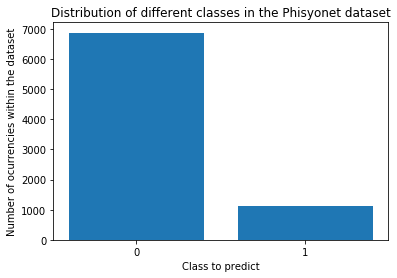

In [38]:
plt.xlabel('Class to predict')
plt.ylabel('Number of ocurrencies within the dataset')
plt.title('Distribution of different classes in the Phisyonet dataset')
labels = ['0', '1']
plt.bar(labels, values)

## Model
This function creates a model that takes multivariate time series binary classification entries. The output will be a sigmoid and the input in this case is for phisyionet. Small changes are required to adapt this function to a different dataset or task.

In [7]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def create_model(gru_layers, units, lr, drop, inputs, skip_connections):
    input_1 = tf.keras.layers.Input(shape=(inputs.shape[1:-1]))
    input_2 = tf.keras.layers.Input(shape=(inputs.shape[1:-1]))
    input_3 = tf.keras.layers.Input(shape=(inputs.shape[1:-1]))
    if gru_layers == 1:
        gru_1 = tf.keras.layers.CuDNNGRU(units)(input_1)
        out_1 = tf.keras.layers.Dropout(drop)(gru_1)
        
        gru_2 = tf.keras.layers.CuDNNGRU(units)(input_2)
        out_2 = tf.keras.layers.Dropout(drop)(gru_2)
        
        gru_3 = tf.keras.layers.CuDNNGRU(units)(input_3)
        out_3 = tf.keras.layers.Dropout(drop)(gru_3)
    else:        
        gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_1)
        skip_1 = tf.keras.layers.Dropout(drop)(gru_1)

        gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_2)
        skip_2 = tf.keras.layers.Dropout(drop)(gru_2)

        gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_3)
        skip_3 = tf.keras.layers.Dropout(drop)(gru_3)
        
        
        for i in range(1, gru_layers):
            if skip_connections:
                if i >1:                    
                    gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_1)
                    res_1 = tf.keras.layers.Dropout(drop)(gru_1)
                    gru_1 = tf.keras.layers.concatenate([res_1, skip_1])
                    skip_1 = res_1

                    gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_2)
                    res_2 = tf.keras.layers.Dropout(drop)(gru_2)
                    gru_2 = tf.keras.layers.concatenate([res_2, skip_2])
                    skip_2 = res_2

                    gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_3)
                    res_3 = tf.keras.layers.Dropout(drop)(gru_3)
                    gru_3 = tf.keras.layers.concatenate([res_3, skip_3])
                    skip_3 = res_3
                else:
                    gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(skip_1)
                    res_1 = tf.keras.layers.Dropout(drop)(gru_1)
                    gru_1 = tf.keras.layers.concatenate([res_1, skip_1])
                    skip_1 = res_1

                    gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(skip_2)
                    res_2 = tf.keras.layers.Dropout(drop)(gru_2)
                    gru_2 = tf.keras.layers.concatenate([res_2, skip_2])
                    skip_2 = res_2

                    gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(skip_3)
                    res_3 = tf.keras.layers.Dropout(drop)(gru_3)
                    gru_3 = tf.keras.layers.concatenate([res_3, skip_3])
                    skip_3 = res_3
                
            else:
                gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_1)
                gru_1 = tf.keras.layers.Dropout(drop)(gru_1)

                gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_2)
                gru_2 = tf.keras.layers.Dropout(drop)(gru_2)

                gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_3)
                gru_3 = tf.keras.layers.Dropout(drop)(gru_3)
        gru_1 = tf.keras.layers.CuDNNGRU(units)(gru_1)
        out_1 = tf.keras.layers.Dropout(drop)(gru_1)
        
        gru_2 = tf.keras.layers.CuDNNGRU(units)(gru_2)
        out_2 = tf.keras.layers.Dropout(drop)(gru_2)
        
        gru_3 = tf.keras.layers.CuDNNGRU(units)(gru_3)
        out_3 = tf.keras.layers.Dropout(drop)(gru_3)
    # End of the gru layers. We must concatenate!
    combined = tf.keras.layers.concatenate([out_1, out_2, out_3])
    
    # Finally the dense computation
    dense = tf.keras.layers.Dense(32, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(drop)(dense)    
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output_layer)
    #opt = tf.keras.optimizers.SGD(lr = lr, nesterov=True)
    opt = tf.keras.optimizers.Adagrad(lr = lr)
    #opt = tf.keras.optimizers.SGD(lr)
    model.compile(optimizer=opt, loss=f1_loss,
             metrics=[tf.keras.metrics.binary_accuracy, f1])
    #model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy,
    #         metrics=[tf.keras.metrics.binary_accuracy, f1])
    return model

In [8]:
def calculate_gradient(y, y_pred, loss_func, x):
    if loss_func == 'binary_class':
        loss = -( (y*np.log(y_pred)) + ( (1-y)*np.log( (1-y_pred) ) ) )
        gradient = (x*(y_pred-y))/y.size
    elif loss_func == 'mse':
        loss = np.sum((y_pred - y)**2) / y.size 
        gradient = -(2*x*(y_pred-y))/y.size
    return gradient

## GRU-D withour MAML <a name='gru_d'></a>

In [9]:
X, X_tst, y, y_tst = train_test_split(X, y, test_size=0.3, random_state=52)

In [10]:
gru_layers = 5
units = 128
lr = 1e-5
drop = 0.2
skip_conn = False
model_full = create_model(gru_layers, units, lr, drop, input_trn, skip_conn)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0)
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='loss', verbose=0,
                                                         save_weights_only=True, save_best_only=True)
callbacks = [callback_early, callback_checkpoint]

In [12]:
mask_X = get_masking(X)
decay_X = np.ndarray(X.shape, dtype='float')
for i in range(mask_X.shape[0]):
    decay_X[i,:,:] = np.transpose(get_decay(X[i,:,-1], np.transpose(mask_X[i,:,:])))

In [13]:
full_history = model_full.fit(x=[X, mask_X, decay_X], y = y[:,-1], callbacks=callbacks, batch_size=128, epochs=30, verbose=0)

Instructions for updating:
Use tf.cast instead.


In [14]:
full_history = full_history.history

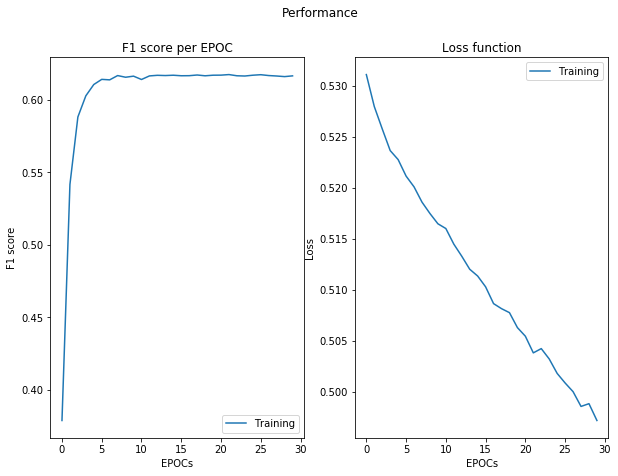

In [15]:
fig, (ax_1, ax_c) = plt.subplots(nrows=1, ncols=2,
                                       sharex=True, figsize=(10, 7))

ax_1.set_title('F1 score per EPOC')
ax_1.plot(full_history['f1'], label='Training')
#ax_1.plot(history.history['val_binary_accuracy'], label='Validation')
ax_1.set_ylabel('F1 score')
ax_1.set_xlabel('EPOCs')
ax_1.legend()

ax_c.set_title('Loss function')
ax_c.plot(full_history['loss'], label='Training')
#ax_c.plot(history.history['val_loss'], label='Validation')
ax_c.set_ylabel('Loss')
ax_c.set_xlabel('EPOCs')
ax_c.legend()

fig.suptitle('Performance')
plt.show()

(array([  68.,  117.,   72.,   28.,   86.,   88., 1582., 1630.,   68.,
           8.]),
 array([0.5496525 , 0.5655034 , 0.58135426, 0.59720516, 0.61305606,
        0.62890697, 0.6447578 , 0.6606087 , 0.6764596 , 0.69231045,
        0.70816135], dtype=float32),
 <a list of 10 Patch objects>)

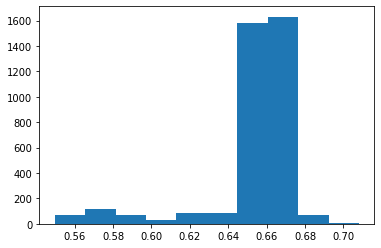

In [15]:
mask_X_tst = get_masking(X_tst)
decay_X_tst = np.ndarray(X_tst.shape, dtype='float')
for i in range(mask_X_tst.shape[0]):
    decay_X_tst[i,:,:] = np.transpose(get_decay(X_tst[i,:,-1], np.transpose(mask_X_tst[i,:,:])))
input_vector = [X_tst, mask_X_tst, decay_X_tst]
y_hat = model_full.predict(input_vector)
y_hat = y_hat.reshape(y_hat.shape[0])
plt.hist(y_hat)

### Evaluation

In [16]:
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
gru_d_f1 = f1_score
print(f1_score)

0.6289748298085309


## MAML <a name='maml'></a>

In [17]:
def maml(tasks, ys, k, array_hp):  
    gru_layers, units, lr, drop, skip_conn = array_hp
    # We create a batch of tasks and its labels on a different array
    b_tasks, b_labels = phisyo_tasks(tasks, ys, k)
    print("Every task has dimention {}".format(b_tasks[0].shape))
    # Initiate the model
    initial_model = create_model(gru_layers, units, lr, drop, b_tasks[0], skip_conn)
    initial_theta = initial_model.get_weights()
    thetas = []
    validation_sets = []
    validation_labels = []
    for i in range(len(b_tasks)):
        X = b_tasks[i,:,:,:,0]
        y = b_labels[i]
        X, X_tst, y, y_tst = train_test_split(X, y, test_size=0.2)
        validation_sets.append(X_tst)
        validation_labels.append(y_tst)

        mask_X = get_masking(X)
        decay_X = np.ndarray(X.shape, dtype='float')
        for i in range(mask_X.shape[0]):
            decay_X[i,:,:] = np.transpose(get_decay(X[i,:,-1], np.transpose(mask_X[i,:,:])))

        initial_model.fit(x=[X, mask_X, decay_X], y = y[:,-1], batch_size=128, epochs=100, verbose=0)
        # Array of optimal weights per task.
        thetas.append(initial_model.get_weights())
        # The weights are restarted for a new task. End of the loop.
        initial_model.set_weights(initial_theta)
    # now that we have optimal weights for all tasks. We modify the starting weights.
    for j in range(len(validation_sets)):
        initial_model.set_weights(thetas[j])
        # We must create the input
        X = validation_sets[j]
        y = validation_labels[j]
        mask_X = get_masking(X)
        decay_X = np.ndarray(X.shape, dtype='float')
        for b in range(mask_X.shape[0]):
            decay_X[b,:,:] = np.transpose(get_decay(X[b,:,-1], np.transpose(mask_X[b,:,:])))
        # We make our prediction to calculate the gradient
        initial_model.fit(x=[X, mask_X, decay_X], y=y[:,-1], epochs=1, verbose=0, batch_size=128)
        initial_theta += initial_model.get_weights()
    initial_theta = np.array(initial_theta)
    #initial_theta = initial_theta/len(thetas)
    initial_model.set_weights(initial_theta)
    return initial_model

In [18]:
gru_layers = 5
units = 128
lr = 1e-5
drop = 0.2
skip_conn = False
hps = [gru_layers, units, lr, drop, skip_conn]
optimal_weigths_model = maml(tasks_phisyonet, task_labels, 10, hps)

Every task has dimention (100, 60, 33, 3)


In [19]:
# Train for a few EPOCs to compare to full model
model_full.set_weights(optimal_weigths_model.get_weights())
maml_history = model_full.fit(x=[X, mask_X, decay_X], callbacks=callbacks, y = y[:,-1], batch_size=128, epochs=30, verbose=0)

In [20]:
maml_history = maml_history.history

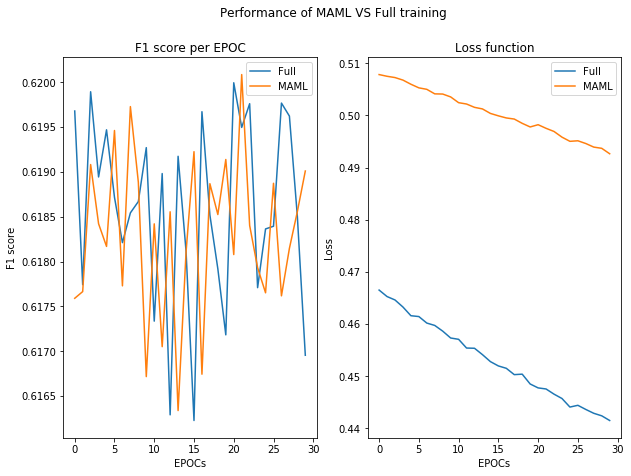

In [30]:
fig, (ax_1, ax_c) = plt.subplots(nrows=1, ncols=2,
                                       sharex=True, figsize=(10, 7))

ax_1.set_title('F1 score per EPOC')
ax_1.plot(full_history['f1'], label='Full')
ax_1.plot(maml_history['f1'], label='MAML')
ax_1.set_ylabel('F1 score')
ax_1.set_xlabel('EPOCs')
ax_1.legend()

ax_c.set_title('Loss function')
ax_c.plot(full_history['loss'], label='Full')
ax_c.plot(maml_history['loss'], label='MAML')
ax_c.set_ylabel('Loss')
ax_c.set_xlabel('EPOCs')
ax_c.legend()

fig.suptitle('Performance of MAML VS Full training')
plt.show()

In [21]:
y_hat = optimal_weigths_model.predict(input_vector)

(array([   4.,   11.,   33.,   47.,  117., 2126., 1035.,  228.,  132.,
          14.]),
 array([0.47054964, 0.47379345, 0.47703725, 0.48028105, 0.48352486,
        0.48676866, 0.49001247, 0.49325627, 0.49650007, 0.49974388,
        0.5029877 ], dtype=float32),
 <a list of 10 Patch objects>)

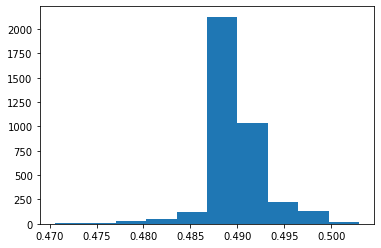

In [22]:
y_hat = y_hat.reshape(y_hat.shape[0])
plt.hist(y_hat)

In [23]:
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
maml_gru_f1 = f1_score
print(f1_score)

0.012716636500858856


## FCN for the task <a name='fcn'></a>

In [24]:
def fcn_model(lr, X_shape):
    input_layer = tf.keras.layers.Input(shape=X_shape[1:])
    # First block of layers
    fcn = tf.keras.layers.Conv1D(64, 8, padding='same')(input_layer)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(64, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(33, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([input_layer, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    first_block=tf.keras.layers.Activation('relu')(fcn)
    # second block
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(first_block)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(66, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([first_block, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    second_block=tf.keras.layers.Activation('relu')(fcn)
    # Third block
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(second_block)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(132, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([second_block, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    third_block=tf.keras.layers.Activation('relu')(fcn)
    # Output
    fcn=tf.keras.layers.GlobalAveragePooling1D()(third_block)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fcn)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    opt = tf.keras.optimizers.Adagrad(lr)
    #opt = tf.keras.optimizers.SGD(lr)
    
    model.compile(optimizer=opt, loss=f1_loss,
             metrics=[tf.keras.metrics.binary_accuracy, f1])
    return model

In [25]:
fcn_network = fcn_model(lr, X.shape)

In [39]:
tf.keras.utils.plot_model(fcn_network,'restnet.png', show_shapes=True)

In [26]:
fcn_history = fcn_network.fit(x=X, y = y[:,-1], batch_size=128, epochs=30, verbose=0)

In [27]:
fcn_history = fcn_history.history

In [28]:
y_hat = fcn_network.predict(X_tst)

In [29]:
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
restnet_f1 = f1_score
print(f1_score)

0.4976033461796388


## MAML FCN <a name='maml_fcn'></a>

In [30]:
def maml_fcn(tasks, ys, k):      
    lr = 1e-5    
    # We create a batch of tasks and its labels on a different array
    b_tasks, b_labels = phisyo_tasks(tasks, ys, k)
    print("Every task has dimention {}".format(b_tasks[0].shape))
    # Initiate the model
    thetas = []
    initial_model = fcn_model(lr, b_tasks[0].shape)
    initial_theta = initial_model.get_weights()
    validation_sets = []
    validation_labels = []
    for i in range(len(b_tasks)):
        X = b_tasks[i,:,:,:]
        y = b_labels[i]
        X, X_tst, y, y_tst = train_test_split(X, y, test_size=0.2)
        validation_sets.append(X_tst)
        validation_labels.append(y_tst)                
        
        initial_model.fit(x=X, y = y[:,-1], batch_size=128, epochs=100, verbose=0)
        # Array of optimal weights per task.
        thetas.append(initial_model.get_weights())
        # The weights are restarted for a new task. End of the loop.
        initial_model.set_weights(initial_theta)
    # now that we have optimal weights for all tasks. We modify the starting weights.
    for i in range(len(thetas)):
        initial_model.set_weights(thetas[i])
        # We must create the input
        X = validation_sets[i]
        y = validation_labels[i]        
        # We make our prediction to calculate the gradient
        initial_model.fit(x=X, y=y[:,-1], epochs=1, verbose=0, batch_size=128)
        initial_theta += initial_model.get_weights()
    initial_theta = np.array(initial_theta)
    #initial_theta = initial_theta/len(thetas)
    initial_model.set_weights(initial_theta)
    return initial_model

In [31]:
tasks_fcn = []
task_labels = []
# We will create 100 different subparts of phisyonet data
for i in range(100):
    x, ys = phisyo_tasks(X, y, 100)
    tasks_fcn.append(x)
    task_labels.append(ys)
tasks_fcn = np.array(tasks_fcn)
task_labels = np.array(task_labels)

In [32]:
optimal_weigths_fcn = maml_fcn(tasks_fcn, task_labels, 10)

Every task has dimention (100, 60, 33)


In [33]:
fcn_network.set_weights(optimal_weigths_fcn.get_weights())
fcn_maml_history = fcn_network.fit(x=X, y = y[:,-1], batch_size=128, epochs=30, verbose=0)

In [34]:
y_hat = fcn_network.predict(X_tst)
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
maml_restnet_f1 = f1_score
print(f1_score)

0.43207475278732727


In [35]:
fcn_maml_history = fcn_maml_history.history

## Plot results of all models

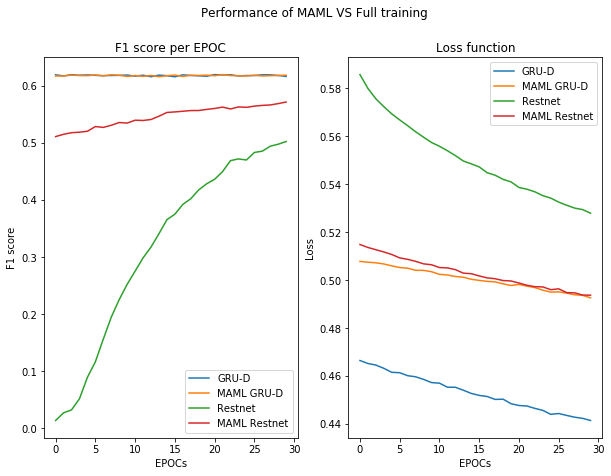

In [45]:
fig, (ax_1, ax_c) = plt.subplots(nrows=1, ncols=2,
                                       sharex=True, figsize=(10, 7))

ax_1.set_title('F1 score per EPOC')
ax_1.plot(full_history['f1'], label='GRU-D')
ax_1.plot(maml_history['f1'], label='MAML GRU-D')
ax_1.plot(fcn_history['f1'], label ='Restnet')
ax_1.plot(fcn_maml_history['f1'], label='MAML Restnet')

ax_1.set_ylabel('F1 score')
ax_1.set_xlabel('EPOCs')
ax_1.legend()

ax_c.set_title('Loss function')
ax_c.plot(full_history['loss'], label='GRU-D')
ax_c.plot(maml_history['loss'], label='MAML GRU-D')
ax_c.plot(fcn_history['loss'], label='Restnet')
ax_c.plot(fcn_maml_history['loss'], label='MAML Restnet')
ax_c.set_ylabel('Loss')
ax_c.set_xlabel('EPOCs')
ax_c.legend()

fig.suptitle('Performance of MAML VS Full training')
plt.show()

In [46]:
print('F1 score GRU-D: {}'.format(gru_d_f1))
print('F1 score MAML GRU-D: {}'.format(maml_gru_f1))
print('F1 score Restnet: {}'.format(restnet_f1))
print('F1 score MAML Restnet: {}'.format(maml_restnet_f1))

F1 score GRU-D: 0.6206472909870901
F1 score MAML GRU-D: 0.056056135930227166
F1 score Restnet: 0.4162474435026202
F1 score MAML Restnet: 0.5067393193292701


## GRU-D with skip connections <a name='gru_skip'></a>

In [36]:
gru_layers = 5
units = 128
lr = 1e-5
drop = 0.2
skip_conn = True
skip_model = create_model(gru_layers, units, lr, drop, input_trn, skip_conn)

In [37]:
gru_skip_history = skip_model.fit(x=[X, mask_X, decay_X], y = y[:,-1], batch_size=128, epochs=30, verbose=0)

In [38]:
gru_skip_history = gru_skip_history.history

In [39]:
y_hat = skip_model.predict([X_tst, mask_X_tst, decay_X_tst])
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
skip_full_f1 = f1_score
print(f1_score)

0.6289748321093457


In [57]:
print('F1 score GRU-D: {}'.format(gru_d_f1))
print('F1 score MAML GRU-D: {}'.format(maml_gru_f1))
print('F1 score Restnet: {}'.format(restnet_f1))
print('F1 score MAML Restnet: {}'.format(maml_restnet_f1))
print('F1 score GRU-D skipconnections: {}'.format(skip_full_f1))

F1 score GRU-D: 0.6206472909870901
F1 score MAML GRU-D: 0.3121534337076276
F1 score Restnet: 0.5519186303515955
F1 score MAML Restnet: 0.5574174758030701
F1 score GRU-D skipconnections: 0.6206472932712329


## MAML skip connections <a name='maml_skip'></a>

In [40]:
gru_layers = 5
units = 128
lr = 1e-5
drop = 0.2
skip_conn = True
hps = [gru_layers, units, lr, drop, skip_conn]
optimal_skip = maml(tasks_phisyonet, task_labels, 10, hps)

Every task has dimention (100, 60, 33, 3)


In [41]:
# Train for a few EPOCs to compare to full model
skip_model.set_weights(optimal_skip.get_weights())
maml_skip_history = skip_model.fit(x=[X, mask_X, decay_X], callbacks=callbacks, y = y[:,-1], batch_size=128, epochs=30, verbose=0)
maml_skip_history = maml_skip_history.history

In [42]:
y_hat = skip_model.predict([X_tst, mask_X_tst, decay_X_tst])
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
skip_maml_f1 = f1_score
print(f1_score)

0.6289748321093457


In [54]:
print('F1 score GRU-D: {}'.format(gru_d_f1))
print('F1 score MAML GRU-D: {}'.format(maml_gru_f1))
print('F1 score Restnet: {}'.format(restnet_f1))
print('F1 score MAML Restnet: {}'.format(maml_restnet_f1))
print('F1 score GRU-D skipconnections: {}'.format(skip_full_f1))
print('F1 score MAML GRU-D skipconnections: {}'.format(skip_maml_f1))

F1 score GRU-D: 0.6206472909870901
F1 score MAML GRU-D: 0.056056135930227166
F1 score Restnet: 0.4162474435026202
F1 score MAML Restnet: 0.5067393193292701
F1 score GRU-D skipconnections: 0.6206472932712329
F1 score MAML GRU-D skipconnections: 0.6206472932712329


In [43]:
def sort_results(results, tags):
    sorted_results = []
    unsorted = results
    while len(unsorted)>0:
        maximum = 0
        max_tag = ''
        elimination = 0
        for i in range(len(unsorted)):
            if unsorted[i] > maximum:
                maximum = unsorted[i]
                max_tag = tags[i]
                elimination = i
        sorted_results.append([maximum, max_tag])
        unsorted.pop(elimination)
        tags.pop(elimination)
    return sorted_results

In [44]:
results_list = [gru_d_f1, maml_gru_f1, restnet_f1, maml_restnet_f1, skip_full_f1, skip_maml_f1]
tags_list = ['GRU-D', 'MAML GRU-D', 'Restnet', 'MAML Restnet', 'GRU-D Skip', 'MAML GRU-D Skip']
sort_results(results_list, tags_list)

[[0.6289748321093457, 'GRU-D Skip'],
 [0.6289748321093457, 'MAML GRU-D Skip'],
 [0.6289748298085309, 'GRU-D'],
 [0.4976033461796388, 'Restnet'],
 [0.43207475278732727, 'MAML Restnet'],
 [0.012716636500858856, 'MAML GRU-D']]

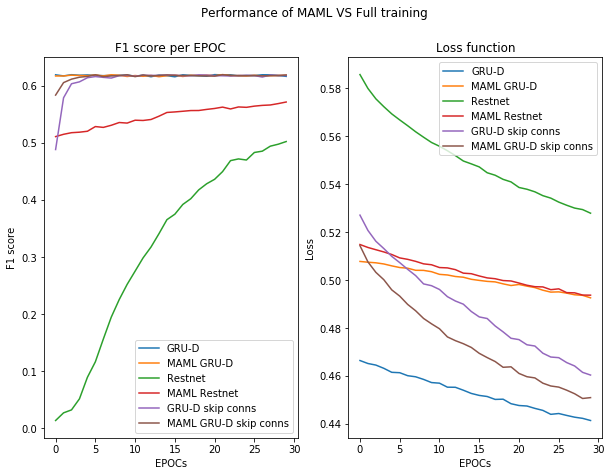

In [57]:
fig, (ax_1, ax_c) = plt.subplots(nrows=1, ncols=2,
                                       sharex=True, figsize=(10, 7))

ax_1.set_title('F1 score per EPOC')
ax_1.plot(full_history['f1'], label='GRU-D')
ax_1.plot(maml_history['f1'], label='MAML GRU-D')
ax_1.plot(fcn_history['f1'], label ='Restnet')
ax_1.plot(fcn_maml_history['f1'], label='MAML Restnet')
ax_1.plot(gru_skip_history['f1'], label='GRU-D skip conns')
ax_1.plot(maml_skip_history['f1'], label='MAML GRU-D skip conns')

ax_1.set_ylabel('F1 score')
ax_1.set_xlabel('EPOCs')
ax_1.legend()

ax_c.set_title('Loss function')
ax_c.plot(full_history['loss'], label='GRU-D')
ax_c.plot(maml_history['loss'], label='MAML GRU-D')
ax_c.plot(fcn_history['loss'], label='Restnet')
ax_c.plot(fcn_maml_history['loss'], label='MAML Restnet')
ax_c.plot(gru_skip_history['loss'], label='GRU-D skip conns')
ax_c.plot(maml_skip_history['loss'], label='MAML GRU-D skip conns')
ax_c.set_ylabel('Loss')
ax_c.set_xlabel('EPOCs')
ax_c.legend()

fig.suptitle('Performance of MAML VS Full training')
plt.show()

## GRU-D with Restnet <a name='gru_rest'></a>

In [45]:
def gru_restnet_network(gru_layers, units, lr, drop, inputs, skip_connections):
    input_1 = tf.keras.layers.Input(shape=(inputs.shape[1:-1]))
    input_2 = tf.keras.layers.Input(shape=(inputs.shape[1:-1]))
    input_3 = tf.keras.layers.Input(shape=(inputs.shape[1:-1]))
    if gru_layers == 1:
        gru_1 = tf.keras.layers.CuDNNGRU(units)(input_1)
        out_1 = tf.keras.layers.Dropout(drop)(gru_1)
        
        gru_2 = tf.keras.layers.CuDNNGRU(units)(input_2)
        out_2 = tf.keras.layers.Dropout(drop)(gru_2)
        
        gru_3 = tf.keras.layers.CuDNNGRU(units)(input_3)
        out_3 = tf.keras.layers.Dropout(drop)(gru_3)
    else:        
        gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_1)
        skip_1 = tf.keras.layers.Dropout(drop)(gru_1)

        gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_2)
        skip_2 = tf.keras.layers.Dropout(drop)(gru_2)

        gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_3)
        skip_3 = tf.keras.layers.Dropout(drop)(gru_3)
        
        
        for i in range(1, gru_layers):
            if skip_connections:
                if i >1:                    
                    gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_1)
                    res_1 = tf.keras.layers.Dropout(drop)(gru_1)
                    gru_1 = tf.keras.layers.concatenate([res_1, skip_1])
                    skip_1 = res_1

                    gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_2)
                    res_2 = tf.keras.layers.Dropout(drop)(gru_2)
                    gru_2 = tf.keras.layers.concatenate([res_2, skip_2])
                    skip_2 = res_2

                    gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_3)
                    res_3 = tf.keras.layers.Dropout(drop)(gru_3)
                    gru_3 = tf.keras.layers.concatenate([res_3, skip_3])
                    skip_3 = res_3
                else:
                    gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(skip_1)
                    res_1 = tf.keras.layers.Dropout(drop)(gru_1)
                    gru_1 = tf.keras.layers.concatenate([res_1, skip_1])
                    skip_1 = res_1

                    gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(skip_2)
                    res_2 = tf.keras.layers.Dropout(drop)(gru_2)
                    gru_2 = tf.keras.layers.concatenate([res_2, skip_2])
                    skip_2 = res_2

                    gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(skip_3)
                    res_3 = tf.keras.layers.Dropout(drop)(gru_3)
                    gru_3 = tf.keras.layers.concatenate([res_3, skip_3])
                    skip_3 = res_3
                
            else:
                gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_1)
                gru_1 = tf.keras.layers.Dropout(drop)(gru_1)

                gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_2)
                gru_2 = tf.keras.layers.Dropout(drop)(gru_2)

                gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_3)
                gru_3 = tf.keras.layers.Dropout(drop)(gru_3)
        gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_1)
        out_1 = tf.keras.layers.Dropout(drop)(gru_1)
        
        gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_2)
        out_2 = tf.keras.layers.Dropout(drop)(gru_2)
        
        gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_3)
        out_3 = tf.keras.layers.Dropout(drop)(gru_3)
    # End of the gru layers. We must concatenate!
    combined = tf.keras.layers.concatenate([out_1, out_2, out_3])
    
    # Restnet module
    fcn = tf.keras.layers.Conv1D(64, 8, padding='same')(combined)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(64, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(33, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([combined, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    first_block=tf.keras.layers.Activation('relu')(fcn)
    # second block
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(first_block)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(66, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([first_block, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    second_block=tf.keras.layers.Activation('relu')(fcn)
    # Third block
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(second_block)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(132, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([second_block, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    third_block=tf.keras.layers.Activation('relu')(fcn)
    # Output
    fcn=tf.keras.layers.GlobalAveragePooling1D()(third_block)
    dense = tf.keras.layers.Dense(32, activation='relu')(fcn)
    
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output_layer)
    #opt = tf.keras.optimizers.SGD(lr = lr, nesterov=True)
    opt = tf.keras.optimizers.Adagrad(lr = lr)
    #opt = tf.keras.optimizers.SGD(lr)
    model.compile(optimizer=opt, loss=f1_loss,
             metrics=[tf.keras.metrics.binary_accuracy, f1])
    #model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy,
    #         metrics=[tf.keras.metrics.binary_accuracy, f1])
    return model

In [46]:
gru_layers = 5
units = 128
lr = 1e-5
drop = 0.2
skip_conn = False
gru_restnet = gru_restnet_network(gru_layers, units, lr, drop, input_trn, skip_conn)

In [47]:
gru_restnet_history = gru_restnet.fit(x=[X, mask_X, decay_X], callbacks=callbacks, y=y[:,-1], batch_size=128, verbose=0, epochs=30)
gru_restnet_history = gru_restnet_history.history

In [48]:
y_hat = gru_restnet.predict([X_tst, mask_X_tst, decay_X_tst])
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
gru_restnet_f1 = f1_score
print(f1_score)

0.5655451444336015


In [49]:
print('F1 score GRU-D: {}'.format(gru_d_f1))
print('F1 score MAML GRU-D: {}'.format(maml_gru_f1))
print('F1 score Restnet: {}'.format(restnet_f1))
print('F1 score MAML Restnet: {}'.format(maml_restnet_f1))
print('F1 score GRU-D skipconnections: {}'.format(skip_full_f1))
print('F1 score MAML GRU-D skipconnections: {}'.format(skip_maml_f1))
print('F1 score GRU-D-Restnet {}'.format(gru_restnet_f1))

F1 score GRU-D: 0.6289748298085309
F1 score MAML GRU-D: 0.012716636500858856
F1 score Restnet: 0.4976033461796388
F1 score MAML Restnet: 0.43207475278732727
F1 score GRU-D skipconnections: 0.6289748321093457
F1 score MAML GRU-D skipconnections: 0.6289748321093457
F1 score GRU-D-Restnet 0.5655451444336015


### GRU-Resnet MAML

In [52]:
def ensemble_maml(tasks, ys, k, array_hp):  
    gru_layers, units, lr, drop, skip_conn = array_hp
    # We create a batch of tasks and its labels on a different array
    b_tasks, b_labels = phisyo_tasks(tasks, ys, k)
    print("Every task has dimention {}".format(b_tasks[0].shape))
    # Initiate the model
    initial_model = gru_restnet_network(gru_layers, units, lr, drop, b_tasks[0], skip_conn)
    initial_theta = initial_model.get_weights()
    thetas = []
    validation_sets = []
    validation_labels = []
    for i in range(len(b_tasks)):
        X = b_tasks[i,:,:,:,0]
        y = b_labels[i]
        X, X_tst, y, y_tst = train_test_split(X, y, test_size=0.2)
        validation_sets.append(X_tst)
        validation_labels.append(y_tst)

        mask_X = get_masking(X)
        decay_X = np.ndarray(X.shape, dtype='float')
        for i in range(mask_X.shape[0]):
            decay_X[i,:,:] = np.transpose(get_decay(X[i,:,-1], np.transpose(mask_X[i,:,:])))

        initial_model.fit(x=[X, mask_X, decay_X], y = y[:,-1], batch_size=128, epochs=100, verbose=0)
        # Array of optimal weights per task.
        thetas.append(initial_model.get_weights())
        # The weights are restarted for a new task. End of the loop.
        initial_model.set_weights(initial_theta)
    # now that we have optimal weights for all tasks. We modify the starting weights.
    for j in range(len(validation_sets)):
        initial_model.set_weights(thetas[j])
        # We must create the input
        X = validation_sets[j]
        y = validation_labels[j]
        mask_X = get_masking(X)
        decay_X = np.ndarray(X.shape, dtype='float')
        for b in range(mask_X.shape[0]):
            decay_X[b,:,:] = np.transpose(get_decay(X[b,:,-1], np.transpose(mask_X[b,:,:])))
        # We make our prediction to calculate the gradient
        initial_model.fit(x=[X, mask_X, decay_X], y=y[:,-1], epochs=1, verbose=0, batch_size=128)
        initial_theta += initial_model.get_weights()
    initial_theta = np.array(initial_theta)
    #initial_theta = initial_theta/len(thetas)
    initial_model.set_weights(initial_theta)
    return initial_model

In [53]:
gru_layers = 5
units = 128
lr = 1e-5
drop = 0.2
skip_conn = True
hps = [gru_layers, units, lr, drop, skip_conn]
optimal_ensemble = ensemble_maml(tasks_phisyonet, task_labels, 10, hps)

Every task has dimention (100, 60, 33, 3)


In [54]:
# Train for a few EPOCs to compare to full model
maml_ensemble_history = optimal_ensemble.fit(x=[X, mask_X, decay_X], callbacks=callbacks, y = y[:,-1], batch_size=128, epochs=30, verbose=0)
maml_ensemble_history = maml_ensemble_history.history

In [55]:
y_hat = optimal_ensemble.predict([X_tst, mask_X_tst, decay_X_tst])
tp = np.sum(np.round(y_hat*y_tst[:,-1]))
tn = np.sum(np.round((1-y_hat)*(1-y_tst[:,-1])))
fp = np.sum(np.round((1-y_hat)*y_tst[:,-1]))
fn = np.sum(np.round(y_hat*(1-y_tst[:,-1])))
p = tp / (tp + fp + 1e-5)
r = tp / (tp + fn + 1e-5)

f1_score = 2*p*r / (p+r+1e-5)
ensemble_f1 = f1_score
print(f1_score)

0.5820175836999304


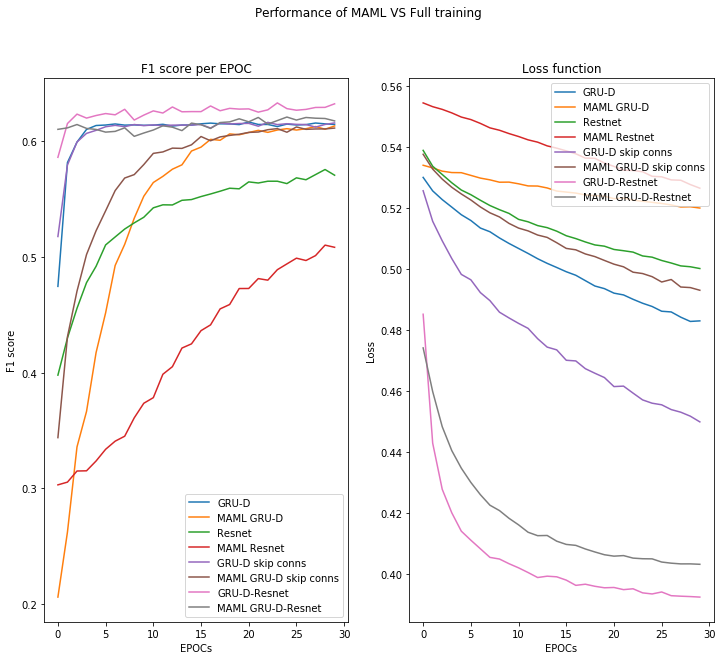

In [88]:
fig, (ax_1, ax_c) = plt.subplots(nrows=1, ncols=2,
                                       sharex=True, figsize=(12, 10))

ax_1.set_title('F1 score per EPOC')
ax_1.plot(full_history['f1'], label='GRU-D')
ax_1.plot(maml_history['f1'], label='MAML GRU-D')
ax_1.plot(fcn_history['f1'], label ='Resnet')
ax_1.plot(fcn_maml_history['f1'], label='MAML Resnet')
ax_1.plot(gru_skip_history['f1'], label='GRU-D skip conns')
ax_1.plot(maml_skip_history['f1'], label='MAML GRU-D skip conns')
ax_1.plot(gru_restnet_history['f1'], label='GRU-D-Resnet')
ax_1.plot(maml_ensemble_history['f1'], label='MAML GRU-D-Resnet')

ax_1.set_ylabel('F1 score')
ax_1.set_xlabel('EPOCs')
ax_1.legend(loc='lower right')

ax_c.set_title('Loss function')
ax_c.plot(full_history['loss'], label='GRU-D')
ax_c.plot(maml_history['loss'], label='MAML GRU-D')
ax_c.plot(fcn_history['loss'], label='Restnet')
ax_c.plot(fcn_maml_history['loss'], label='MAML Restnet')
ax_c.plot(gru_skip_history['loss'], label='GRU-D skip conns')
ax_c.plot(maml_skip_history['loss'], label='MAML GRU-D skip conns')
ax_c.plot(gru_restnet_history['loss'], label='GRU-D-Restnet')
ax_c.plot(maml_ensemble_history['loss'], label='MAML GRU-D-Restnet')
ax_c.set_ylabel('Loss')
ax_c.set_xlabel('EPOCs')
ax_c.legend(loc='upper right')

fig.suptitle('Performance of MAML VS Full training')
fig.savefig("Results of Phisyonet")
plt.show()

In [57]:
results_list = [gru_d_f1, maml_gru_f1, restnet_f1, maml_restnet_f1, skip_full_f1, skip_maml_f1, gru_restnet_f1, ensemble_f1]
tags_list = ['GRU-D', 'MAML GRU-D', 'Restnet', 'MAML Restnet', 'GRU-D Skip', 'MAML GRU-D Skip', 'GRU-Restnet', 'MAML ensemble']
sort_results(results_list, tags_list)

[[0.6289748321093457, 'GRU-D Skip'],
 [0.6289748321093457, 'MAML GRU-D Skip'],
 [0.6289748298085309, 'GRU-D'],
 [0.5820175836999304, 'MAML ensemble'],
 [0.5655451444336015, 'GRU-Restnet'],
 [0.4976033461796388, 'Restnet'],
 [0.43207475278732727, 'MAML Restnet'],
 [0.012716636500858856, 'MAML GRU-D']]

# M4 Dataset <a name='m4'></a>

In [58]:
df_m4 = pd.read_csv('Datasets/M4/M4DataSet/Hourly-train.csv')
df_yearly = pd.read_csv('Datasets/M4/M4DataSet/Yearly-train.csv')
df_daily = pd.read_csv('Datasets/M4/M4DataSet/Daily-train.csv')
df_monthly = pd.read_csv('Datasets/M4/M4DataSet/Monthly-train.csv')
df_quaterly = pd.read_csv('Datasets/M4/M4DataSet/Quarterly-train.csv')

In [59]:
dfs = [df_m4, df_yearly, df_daily, df_monthly, df_quaterly]

In [60]:
# The dataset hould be from M4, that has the first entry per row as a not number ariable
def plot_ts_randomly(dataset, number_rows, number_columns):
    rows = number_rows
    cols = number_columns
    fig, axs = plt.subplots(nrows=rows, ncols=cols,
                                           sharex=True, figsize=(20, 14))
    for row in range(rows):
        for col in range(cols):
            ax = axs[row, col]
            index = np.random.randint(dataset.shape[0])
            ts = dataset.iloc[index]
            ax.plot(ts[1:])
            ax.set_title('Entry N° '+ str(index))
            ax.set_xlabel('Timestamp')
            ax.axes.xaxis.set_ticklabels([])
    fig.suptitle('Random plots of Yearly DataSet')
    plt.show()

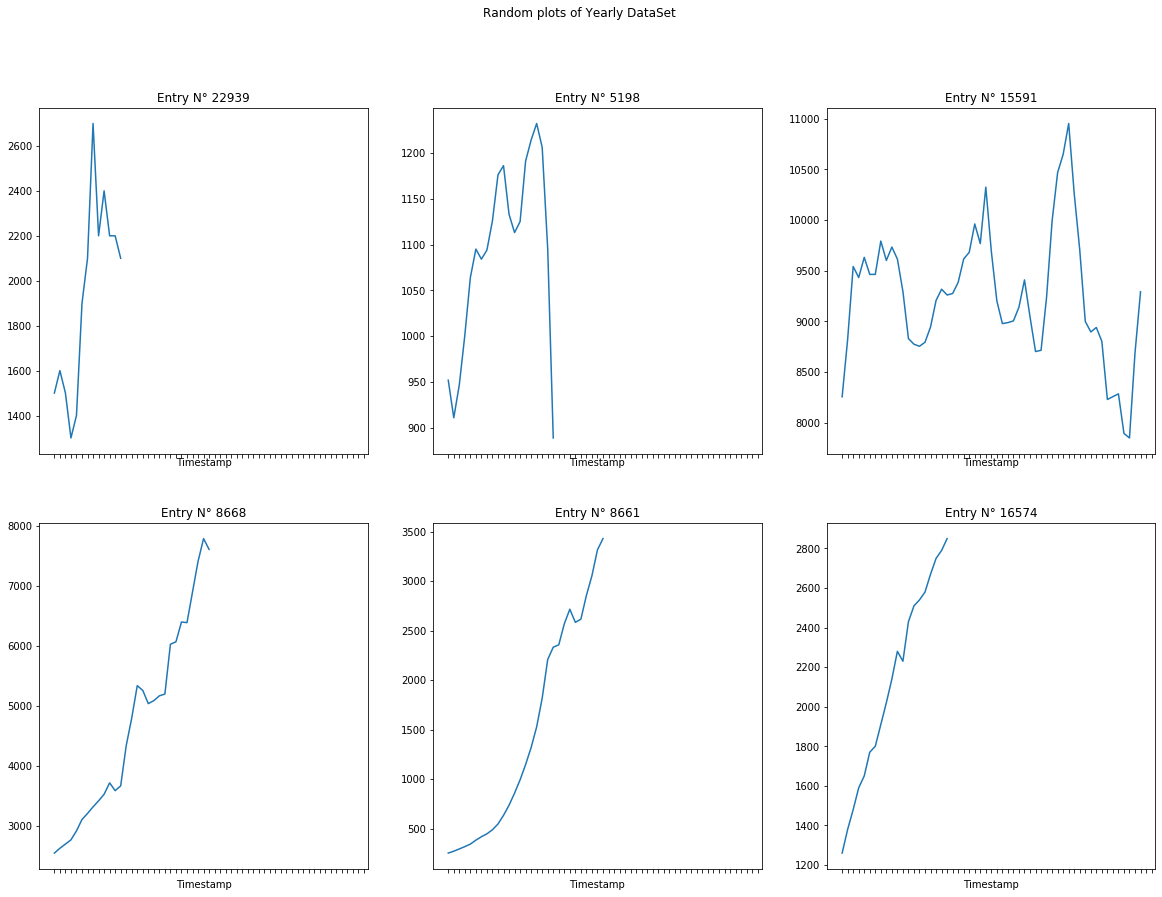

In [35]:
plot_ts_randomly(df_yearly, 2, 3)

## Tasks preparation

In [4]:
df_m4.shape, df_yearly.shape, df_daily.shape, df_monthly.shape, df_quaterly.shape

((414, 961), (23000, 836), (4227, 9920), (48000, 2795), (24000, 867))

In [64]:
print(df_daily.isna().sum(axis=1).min(), df_daily.isna().sum(axis=1).max())
# There are TS with all 9920 values and there are time series with onyly 5694 values.
# It cannot be just cropping all rows by columns to fix 836 values. That would give time series of only NANs.
# The model could be doing time series with 100 entries to see how it goes.
# The minimum amount of columns is 836.
## tf.keras.preprocessing.sequence.pad_sequences(set_A, maxlen = 60, dtype='float', padding='pre', truncating='pre', value=-1)

0 9826


In [70]:
for df in dfs:
    print((df.shape[1]-df.isna().sum(axis=1)).min())

701
14
94
43
17


In [61]:
# There are certainly time series that could be discarted on almost all datasets.
# We could define a window for the training, around 256 for example and get all time series that have more than 256 entries
# Then use sliding window to create more data and then use as tasks for MAML to do its job.
def create_tasks(dfs, window_size):
    answer = []
    for df in dfs:
        data = df.drop('V1', axis=1).values
        temp_data = []
        for row in data:
            if row.size-np.isnan(row).sum()>window_size:
                temp_data.append(row)
        temp_data = np.array(temp_data)
        answer.append(temp_data)
    answer = np.array(answer)
    return answer

In [62]:
tasks = create_tasks(dfs, 200)

In [6]:
for i in range(len(dfs)):
    print(tasks[i].shape, dfs[i].shape)

(414, 960) (414, 961)
(80, 835) (23000, 836)
(3961, 9919) (4227, 9920)
(24547, 2794) (48000, 2795)
(574, 866) (24000, 867)


The sequences in the data have a minimum of 200 float entries followed by NAN values. All sequences have the same length when adding NANs. However the entry points is minimum 200.
## Functions for model

In [176]:
def get_task_ready(task):
    # Making all sequences of the same length
    task = tf.keras.preprocessing.sequence.pad_sequences(task, maxlen=200, dtype='float', padding='pre', truncating='post', value=np.nan)
    # Normalization
    min_norm = np.nanmin(task)
    max_norm = np.nanmax(task)
    task = (task-min_norm)/(max_norm-min_norm)
    # Getting Training data and testing data
    X = task[:,:100]
    y = task[:,100]
    X_tst = task[:,99:-1]
    y_tst = task[:,-1:]
    # Adding an extra dimention to X in order to be a time seires
    X = np.expand_dims(X, axis=-1)
    X_tst = np.expand_dims(X_tst, axis=-1)
    y = np.expand_dims(y, axis=-1)
    # Training, test and validation
    X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=60)
    return {'X':X, 'X_tst':X_tst, 'X_val':X_val, 'y':y, 'y_tst':y_tst, 'y_val':y_val, 'min':min_norm, 'max':max_norm}

In [177]:
dictionaries = []
for t in tasks:
    dictionaries.append(get_task_ready(t))

In [9]:
for d in dictionaries:
    print(d['X'].shape, d['X_val'].shape, d['X_tst'].shape)
    print(d['y'].shape, d['y_val'].shape, d['y_tst'].shape)

(331, 100, 1) (83, 100, 1) (414, 100, 1)
(331, 1) (83, 1) (414, 1)
(64, 100, 1) (16, 100, 1) (80, 100, 1)
(64, 1) (16, 1) (80, 1)
(3168, 100, 1) (793, 100, 1) (3961, 100, 1)
(3168, 1) (793, 1) (3961, 1)
(19637, 100, 1) (4910, 100, 1) (24547, 100, 1)
(19637, 1) (4910, 1) (24547, 1)
(459, 100, 1) (115, 100, 1) (574, 100, 1)
(459, 1) (115, 1) (574, 1)


In [117]:
def GRU_M4(num_layers, units, lr, drop, skip, shape_x, shape_y):
    if num_layers<2:
        print('I do not work with less than 2 GRU layers mate! Your model is non-existing')
        return None
    input_layer = tf.keras.layers.Input(shape= shape_x[1:])
    gru = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_layer)
    inp = tf.keras.layers.Dropout(drop)(gru)
    for i in range(1, num_layers-1):
        gru = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(inp)
        if skip:
            gru = tf.keras.layers.Dropout(drop)(gru)
            inp = tf.keras.layers.concatenate([gru, inp])
        else:
            inp = tf.keras.layers.Dropout(drop)(gru)
    gru = tf.keras.layers.CuDNNGRU(units)(inp)
    inp = tf.keras.layers.Dropout(drop)(gru)
    gru = tf.keras.layers.Dense(64)(inp)
    #gru = tf.keras.layers.Dense(64, activation='relu')(inp)
    gru = tf.keras.layers.Dropout(drop)(gru)
    #output_layer = tf.keras.layers.Dense(shape_y[-1], activation='sigmoid')(gru)
    output_layer = tf.keras.layers.Dense(shape_y[-1])(gru)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    opt = tf.keras.optimizers.Adagrad(lr)
    model.compile(optimizer=opt, loss=tf.keras.losses.mse, metrics=[tf.keras.metrics.mae,
                                                                                 tf.keras.metrics.mse])
    return model    

In [178]:
# Task 0
X = dictionaries[0]['X']
X_val = dictionaries[0]['X_val']
y = dictionaries[0]['y']
y_val = dictionaries[0]['y_val']
min_norm = dictionaries[0]['min']
max_norm = dictionaries[0]['max']

In [119]:
def get_k_from_X(k, X, y):
    added = []
    answer = []
    ans = []
    i=0
    while i<k:
        index = np.random.randint(X.shape[0]-1)
        if index not in added:
            added.append(index)
            answer.append(X[index])
            ans.append(y[index])
            i+=1
    return np.array(answer), np.array(ans)

In [179]:
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = True
model = GRU_M4(layers, units, lr, dr, skip, X.shape, y.shape)

In [69]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=0,
                                                         save_weights_only=True, save_best_only=True)
callbacks = [callback_early, callback_checkpoint]

In [180]:
history = model.fit(x=X, y=y, verbose=0, callbacks=callbacks, epochs=500, batch_size=16, validation_data=[X_val, y_val])

In [141]:
history=history.history

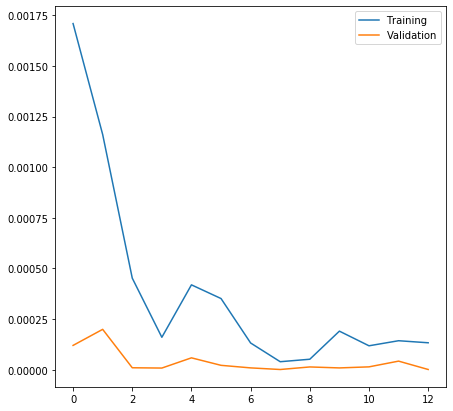

In [17]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.gcf().set_size_inches(7,7)
plt.legend()

In [181]:
plotters = []
for i in range(0, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [182]:
np.save('plotters_60', plotters)

In [183]:
F = -plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
print(mse)

F = -plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
print(mse)

F = -plotters[2][0].flatten()
A = plotters[2][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
print(mse)

F = -plotters[4][0].flatten()
A = plotters[4][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
print(mse)

40.985
50.0
49.937
50.0


In [103]:
plotters[0][0].flatten().shape

(414,)

In [75]:
# index 0 is the forecat, index 1 is the actual value
# The formlua for smape is (100%/n)(|F-A|)/(|F|+|A|)/2
F = plotters[0][0].flatten()
A = plotters[0][1]
np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

48.324

In [76]:
np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

0.0048

In [77]:
plotters[2][0].flatten().shape

(3961,)

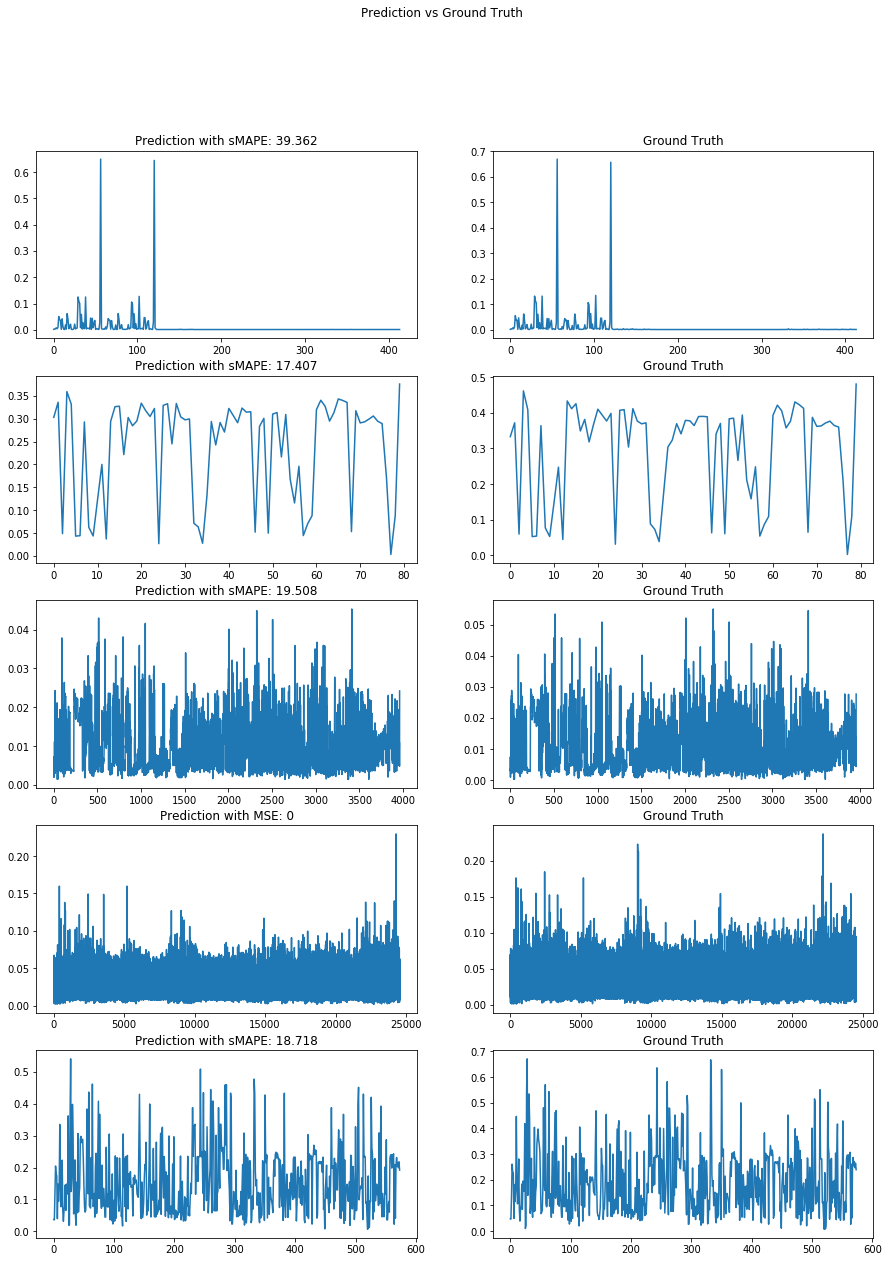

In [144]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

F = plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)

F = plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
#mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)

F = plotters[2][0].flatten()
A = plotters[2][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
mse = 0
ax.set_title('Prediction with MSE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[4,0]
ax.plot(plotters[4][0].flatten(), label='Predictions')
#mse=0
#mse = np.mean((plotters[4][0].flatten()-plotters[4][1])**2).round(4)

F = plotters[4][0].flatten()
A = plotters[4][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[4,1]
ax.plot(plotters[4][1], label='Ground Truth')
ax.set_title('Ground Truth')

fig.suptitle('Prediction vs Ground Truth')
fig.savefig("GRU_M4_11")

In [79]:
def plot_results(y_hat, y, cols, rows):    
    fig, axs = plt.subplots(nrows=rows, ncols=cols,
                                           sharex=True, figsize=(15, 20))
    added_indexes = []
    for row in range(rows):
        for col in range(cols):
            bool_ad=False
            ax = axs[row, col]
            while bool_ad!=True:              
                index = np.random.randint(y_hat.shape[0])    
                if index not in added_indexes:
                    ax.plot(y_hat[index], label='Prediction')
                    ax.plot(y[index], label='Ground Truth')
                    mse = ((y_hat[index]-y_tst[index])**2).mean()
                    ax.legend(loc='lower right')
                    ax.set_title('Entry N° '+ str(index)+', MSE: '+str(mse))
                    added_indexes.append(index)
                    bool_ad = True
    fig.suptitle('Random plots of Prediction vs Ground Truth')
    plt.show()

In [80]:
# Unnormalize
y_tst = min_norm+y_tst*(max_norm-min_norm)
yp = min_norm+yp*(max_norm-min_norm)

In [81]:
rmse = ((yp-y_tst)**2).mean()
print("The RMSE for the GRU is {}".format(rmse))

The RMSE for the GRU is 6430265226.676712


In [82]:
def fcn_m4(X_shape, y_shape, lr):
    input_layer = tf.keras.layers.Input(shape=X_shape[1:])
    # First block of layers
    fcn = tf.keras.layers.Conv1D(64, 8, padding='same')(input_layer)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(64, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(33, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([input_layer, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    first_block=tf.keras.layers.Activation('relu')(fcn)
    # second block
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(first_block)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(66, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([first_block, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    second_block=tf.keras.layers.Activation('relu')(fcn)
    # Third block
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(second_block)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(128, 8, padding='same')(fcn)
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    fcn=tf.keras.layers.Activation('relu')(fcn)
    fcn = tf.keras.layers.Conv1D(132, 8, padding='same')(fcn)
    fcn = tf.keras.layers.concatenate([second_block, fcn])
    fcn=tf.keras.layers.BatchNormalization()(fcn)
    third_block=tf.keras.layers.Activation('relu')(fcn)
    # Output
    fcn=tf.keras.layers.GlobalAveragePooling1D()(third_block)
    #output_layer = tf.keras.layers.Dense(y_shape[-1], activation='sigmoid')(fcn)
    output_layer = tf.keras.layers.Dense(y_shape[-1])(fcn)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    opt = tf.keras.optimizers.Adagrad(lr)
    #opt = tf.keras.optimizers.SGD(lr)
    
    model.compile(optimizer=opt, loss=tf.keras.losses.mse,
             metrics=[tf.keras.metrics.mse])
    return model

In [145]:
model = fcn_m4(X.shape, y.shape, lr)

In [146]:
history = model.fit(x=X, y=y, validation_data=[X_val, y_val], epochs=500, verbose = 0, batch_size=16)

In [147]:
history= history.history

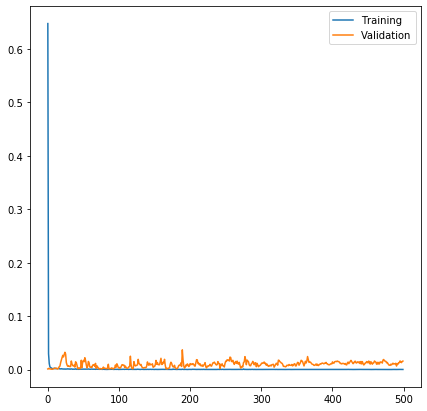

In [17]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.gcf().set_size_inches(7,7)
plt.legend()

In [148]:
plotters = []
for i in range(0, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [149]:
np.save('plotters_fcn_11', plotters)

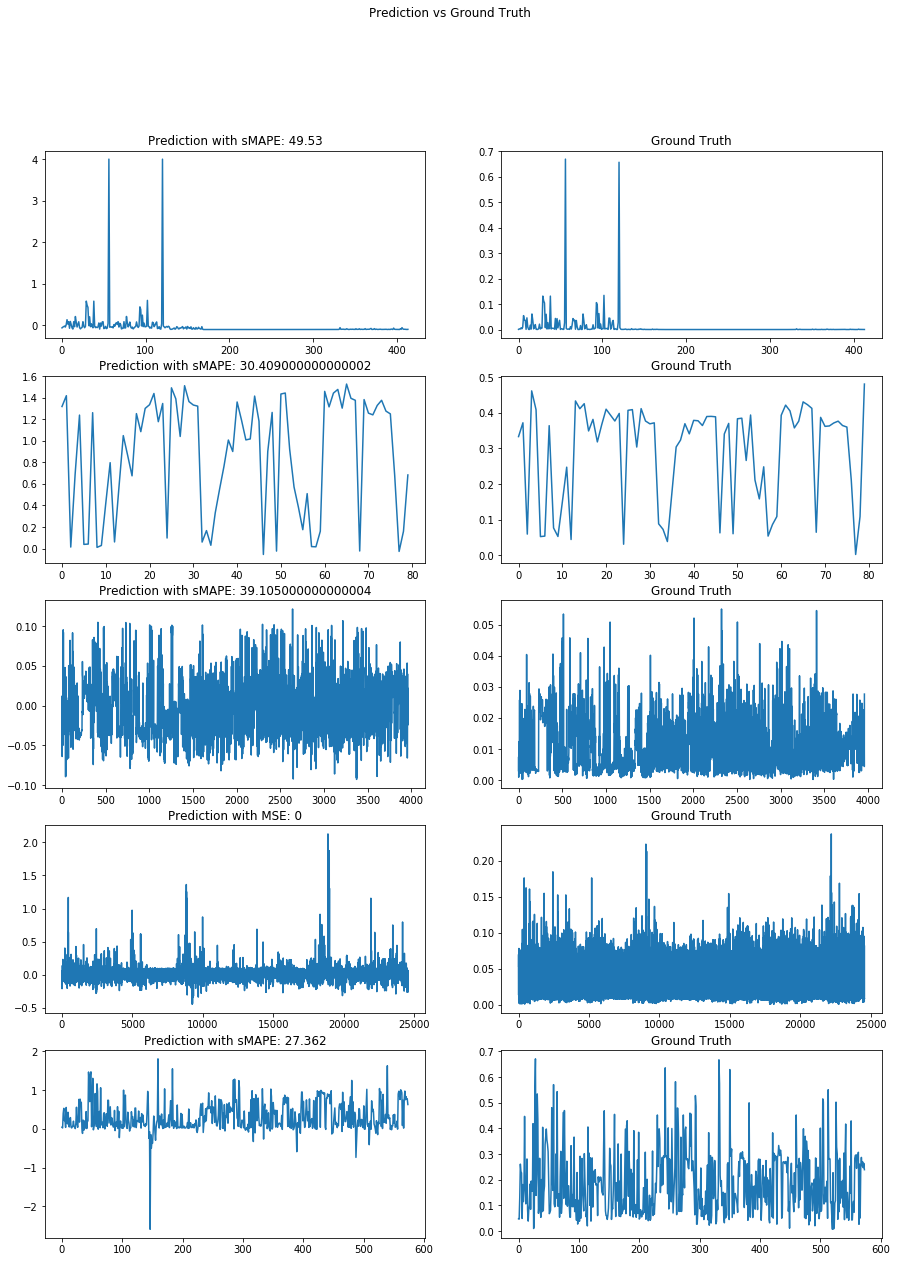

In [150]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

F = plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)

F = plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
#mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)

F = plotters[2][0].flatten()
A = plotters[2][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
mse = 0
ax.set_title('Prediction with MSE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[4,0]
ax.plot(plotters[4][0].flatten(), label='Predictions')
#mse=0
#mse = np.mean((plotters[4][0].flatten()-plotters[4][1])**2).round(4)

F = plotters[4][0].flatten()
A = plotters[4][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[4,1]
ax.plot(plotters[4][1], label='Ground Truth')
ax.set_title('Ground Truth')

fig.suptitle('Prediction vs Ground Truth')
fig.savefig("Restnet_M4_11")

## MAML for M4 <a name='maml_m4'></a>

In [90]:
def maml_m4(k, gru_layers, units, skip, lr, drop, dictionaries):
    X = dictionaries[0]['X']    
    X_val = dictionaries[0]['X_val']
    y = dictionaries[0]['y']
    y_val = dictionaries[0]['y_val']
    X, y = get_k_from_X(k, X, y)
    model = GRU_M4(gru_layers, units, lr, drop, skip, X.shape, y.shape)
    initial_weigths = model.get_weights()
    XV = [X_val[np.random.randint(X_val.shape[0]-1)]]
    YV = [y_val[np.random.randint(y_val.shape[0]-1)]]
    model.fit(x=X, y=y, verbose=0, epochs=k, batch_size=16)
    thetas = [model.get_weights()]
    model.set_weights(initial_weigths)
    for i in range(1, len(dictionaries)):
        X = dictionaries[1]['X']    
        X_val = dictionaries[1]['X_val']
        y = dictionaries[1]['y']
        y_val = dictionaries[1]['y_val']
        X, y = get_k_from_X(k, X, y)
        XV.append(X_val[np.random.randint(X_val.shape[0]-1)])
        YV.append(y_val[np.random.randint(y_val.shape[0]-1)])
        model.fit(x=X, y=y, verbose=0, epochs=k, batch_size=16)
        thetas.append(model.get_weights())
        model.set_weights(initial_weigths)
    for i in range(len(XV)):
        model.set_weights(thetas[i])
        X = XV[i]
        y = YV[i]
        X = np.expand_dims(X, axis=0)
        model.fit(x=X, y=y, verbose=0, epochs=1, batch_size=16)
        initial_weigths+=model.get_weights()
    model.set_weights(initial_weigths)
    return model

In [151]:
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = True
maml_m4_model = maml_m4(20, layers, units, skip, lr, dr, dictionaries)

In [152]:
plotters = []
for i in range(0, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = maml_m4_model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [153]:
np.save('plotters_maml_11', plotters)

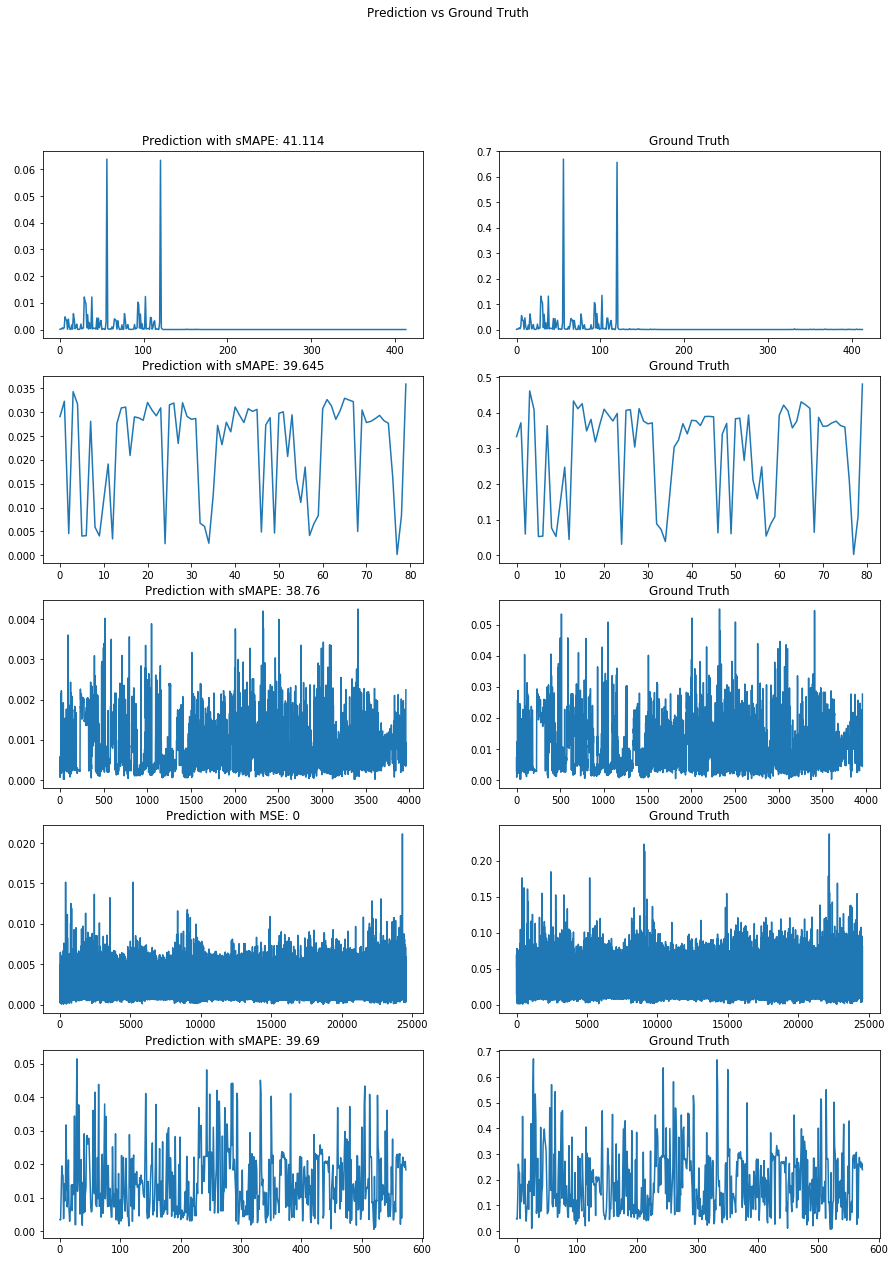

In [156]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(-plotters[0][0].flatten(), label='Predictions')
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

F = -plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(-plotters[1][0].flatten(), label='Predictions')
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)

F = -plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(-plotters[2][0].flatten(), label='Predictions')
#mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)

F = -plotters[2][0].flatten()
A = plotters[2][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(-plotters[3][0].flatten(), label='Predictions')
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
mse = 0
ax.set_title('Prediction with MSE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[4,0]
ax.plot(-plotters[4][0].flatten(), label='Predictions')
#mse=0
#mse = np.mean((plotters[4][0].flatten()-plotters[4][1])**2).round(4)

F = -plotters[4][0].flatten()
A = plotters[4][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[4,1]
ax.plot(plotters[4][1], label='Ground Truth')
ax.set_title('Ground Truth')

fig.suptitle('Prediction vs Ground Truth')
fig.savefig("maml_m4_11")

## HPs 

In [130]:
rmse_fcn = ((yp-y_tst)**2).mean()
print("The RMSE for the GRU is {}".format(rmse))
print("The RMSE for the FCN is {}".format(rmse_fcn))
print(rmse-rmse_fcn)

The RMSE for the GRU is 8.409719992222606e-05
The RMSE for the FCN is 0.00025325068841193765
-0.00016915348848971158


In [114]:
b_sizes=[64,128,32,16]
for b in b_sizes:
    try:
        model = GRU_M4(layers, units, lr, dr, skip, X.shape, y.shape)
        history = model.fit(x=X, y=y, verbose=0, callbacks=callbacks, epochs=100, batch_size=b, validation_data=[X_val, y_val])
        history = history.history
        mse = np.mean(history['loss'])
        print("For batchsize {} the mse is {}".format(b, mse))
    except:
        print('Batchsize {} is not doable in the current Hardware'.format(b))


For batchsize 64 the mse is 0.03671485769534202
For batchsize 128 the mse is 0.04896182472874044
For batchsize 32 the mse is 0.024745831020373962
For batchsize 16 the mse is 0.014327809775766746


## Doing just one TS <a name='one_ts'></a>

In [78]:
for t in tasks:
    print(t.shape)

(414, 960)
(80, 835)
(3961, 9919)
(24547, 2794)
(574, 866)


In [41]:
t = tasks[3]
temp_min = t.shape[1]
best_ts = None
for ts in t:
    temp_nans = np.isnan(ts).sum()
    if temp_nans<=temp_min:
        best_ts = ts
        temp_min = temp_nans

In [42]:
norm_min = np.nanmin(best_ts)
norm_max = np.nanmax(best_ts)
denominator = norm_max-norm_min
temp_ts = (best_ts-norm_min)/denominator
best_ts = (best_ts-np.mean(best_ts))/np.std(best_ts)
print(best_ts.shape)

(2794,)


In [43]:
used_indexes = []
added = 0
sequences = []
while added<best_ts.size-102:
    index = np.random.randint(101, best_ts.size)
    if index not in used_indexes:
        sequences.append(best_ts[index-101:index])
        added+=1
        used_indexes.append(index)
sequences=np.array(sequences)
sequences.shape

(2692, 101)

In [44]:
X = sequences[:,:-1]
X = np.expand_dims(X, axis=-1)
y = sequences[:,-1]
y = np.expand_dims(y, axis=-1)
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2)
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = True

In [45]:
model = GRU_M4(layers, units, lr, dr, skip, X.shape, y.shape)

In [46]:
history = model.fit(x=X, y=y, verbose=0, callbacks=callbacks, epochs=100, batch_size=32, validation_data=[X_val, y_val])

In [47]:
history = history.history

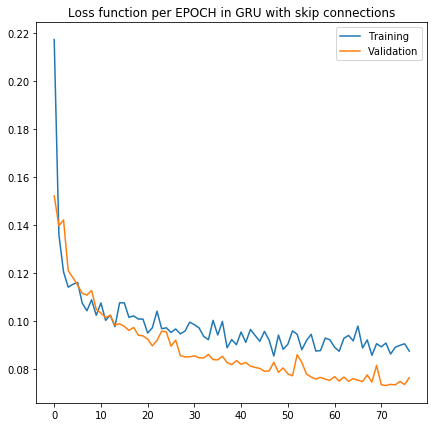

In [49]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title("Loss function per EPOCH in GRU with skip connections")
plt.gcf().set_size_inches(7,7)
plt.legend()

In [50]:
predictions = []
maml_predictions = []
for i in range(101, best_ts.size-2):
    input_predict=best_ts[i-100:i]
    input_predict = np.expand_dims(input_predict, axis=-1)
    input_predict = np.array([input_predict])
    yp = model.predict(input_predict)
    yp_maml = maml_m4_model.predict(input_predict)
    predictions.append(yp)
    maml_predictions.append(yp_maml)

In [51]:
maml_predictions = np.array(maml_predictions).flatten()
predictions = np.array(predictions).flatten()

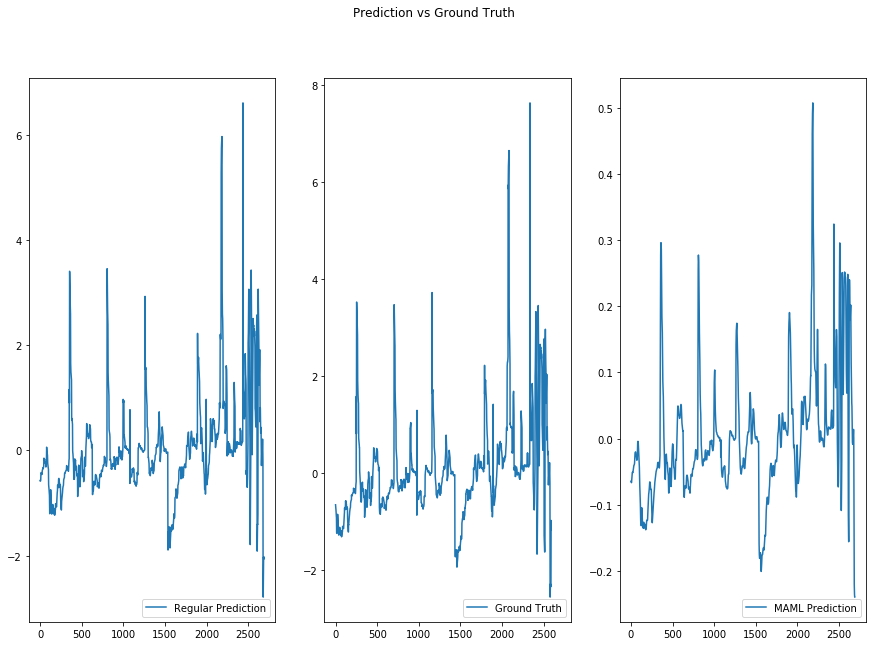

In [53]:

fig, [ax_1, ax_2, ax_3] = plt.subplots(nrows=1, ncols=3,
                                           sharex=True, figsize=(15, 10))

ax_1.plot(predictions, label='Regular Prediction')

ax_1.legend(loc='lower right')
fig.suptitle('Prediction vs Ground Truth')

ax_2.plot(best_ts[201:], label='Ground Truth')
ax_2.legend(loc='lower right')

ax_3.plot(-1*maml_predictions, label="MAML Prediction")
ax_3.legend(loc='lower right')
plt.show()
fig.savefig("MAML_window")

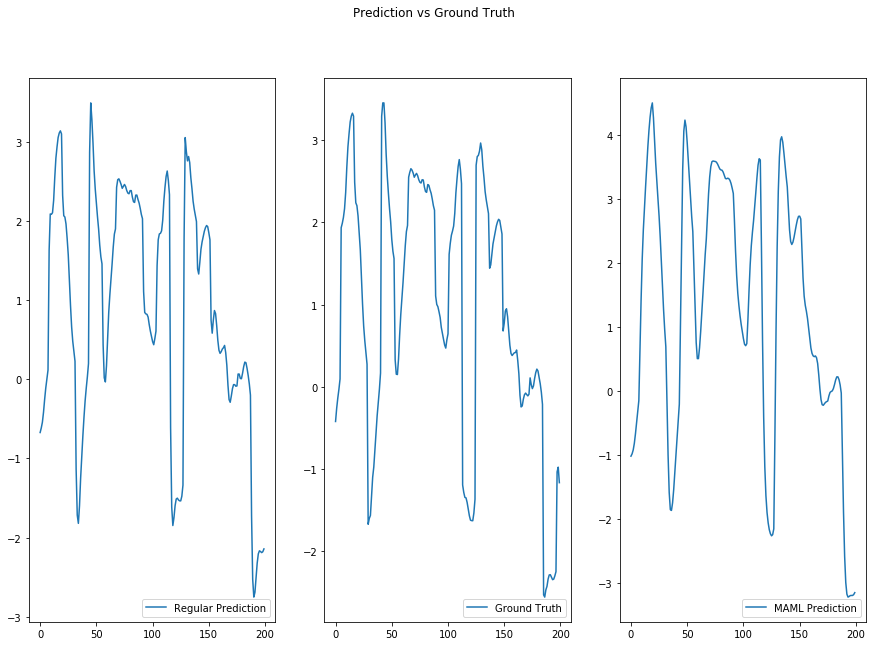

In [123]:

fig, [ax_1, ax_2, ax_3] = plt.subplots(nrows=1, ncols=3,
                                           sharex=True, figsize=(15, 10))

ax_1.plot(predictions[-200:], label='Regular Prediction')

ax_1.legend(loc='lower right')
fig.suptitle('Prediction vs Ground Truth')

ax_2.plot(best_ts[-200:], label='Ground Truth')
ax_2.legend(loc='lower right')

ax_3.plot(-10*maml_predictions[-200:], label="MAML Prediction")
ax_3.legend(loc='lower right')
plt.show()

## M4 with missing values <a name='m4_missing'></a>

In [13]:
def masking_task(task):
    task = task.reshape(task.shape[:-1])
    answer = np.where(task!=-1, 1, task)
    answer = np.where(task==-1, 0, answer)
    answer = np.expand_dims(answer, axis=-1)
    return answer
# since there is no timestamps, every S will be equal to 1. (Timestamp array)
def decaying_task(mask):
    mask = mask.reshape(mask.shape[:-1])
    answer = []
    for row in mask:
        decay_row = [0]
        for i in range(1, len(row)):
            if row[i-1] == 0:
                decay_t = 1+decay_row[i-1]
            else:
                decay_t = 1
            decay_row.append(decay_t)
        answer.append(decay_row)
    answer = np.array(answer)
    answer = np.expand_dims(answer, axis=-1)
    return answer

In [ ]:
def transform_m4(M4):
    m4v2 = []
    for row in M4:
        for i in range(row.size//3):
            index = np.random.ranindt(row.size-1)
            row[index] = -1
        m4v2.append(row)
    return m4v2

In [14]:
def get_task_ready_missing(task):
    # Making all sequences of the same length
    task = tf.keras.preprocessing.sequence.pad_sequences(task, maxlen=200, dtype='float', padding='pre', truncating='post', value=np.nan)
    # Normalization
    min_norm = np.nanmin(task)
    max_norm = np.nanmax(task)
    task = (task-min_norm)/(max_norm-min_norm)
    for row in range(len(task)):
        for i in range(task.shape[1]//10):
            index = np.random.randint(task[row].size-1)
            task[row][index] = -1
    # Getting Training data and testing data
    X = task[:,:100]
    y = task[:,100]
    X_tst = task[:,99:-1]
    y_tst = task[:,-1:]
    # Adding an extra dimention to X in order to be a time seires
    X = np.expand_dims(X, axis=-1)
    X_tst = np.expand_dims(X_tst, axis=-1)
    y = np.expand_dims(y, axis=-1)
    # Training, test and validation
    X, X_val, y, y_val = train_test_split(X, y, test_size=0.2)
    # Creating the masks
    mask_X = masking_task(X)
    mask_tst = masking_task(X_tst)
    mask_val = masking_task(X_val)
    # Creating the decays
    decay_X = decaying_task(mask_X)
    decay_tst = decaying_task(mask_tst)
    decay_val = decaying_task(mask_val)
    return {'X':X, 'X_tst':X_tst, 'X_val':X_val, 'y':y, 'y_tst':y_tst, 'y_val':y_val, 'min':min_norm, 'max':max_norm,
           'mask_X':mask_X, 'mask_tst':mask_tst, 'mask_val':mask_val, 
            'decay_X':decay_X, 'decay_tst':decay_tst, 'decay_val':decay_val}

In [15]:
dictionaries = []
for t in tasks:
    dictionaries.append(get_task_ready_missing(t))

In [16]:
# Trying the GRU Model without missing in this data
# Task 0
X = dictionaries[0]['X']
X_val = dictionaries[0]['X_val']
y = dictionaries[0]['y']
y_val = dictionaries[0]['y_val']
min_norm = dictionaries[0]['min']
max_norm = dictionaries[0]['max']

In [17]:
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = True
model = GRU_M4(layers, units, lr, dr, skip, X.shape, y.shape)
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=0,
                                                         save_weights_only=True, save_best_only=True)
callbacks = [callback_early, callback_checkpoint]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
history = model.fit(x=X, y=y, verbose=0, callbacks=callbacks, epochs=500, batch_size=16, validation_data=[X_val, y_val])

Instructions for updating:
Use tf.cast instead.


In [19]:
history = history.history

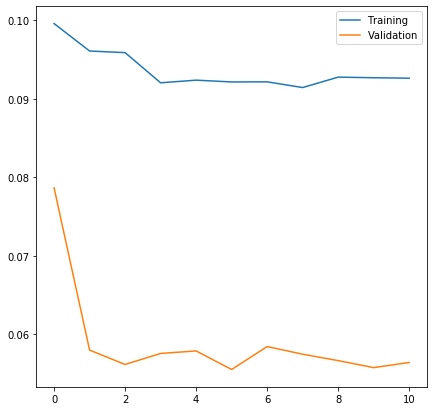

In [20]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.gcf().set_size_inches(7,7)
plt.legend()

In [ ]:
plotters = []
for i in range(1, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [17]:
#np.save("plotters_missing_gru", plotters)
plotters = np.load("plotters_missing_gru.npy")

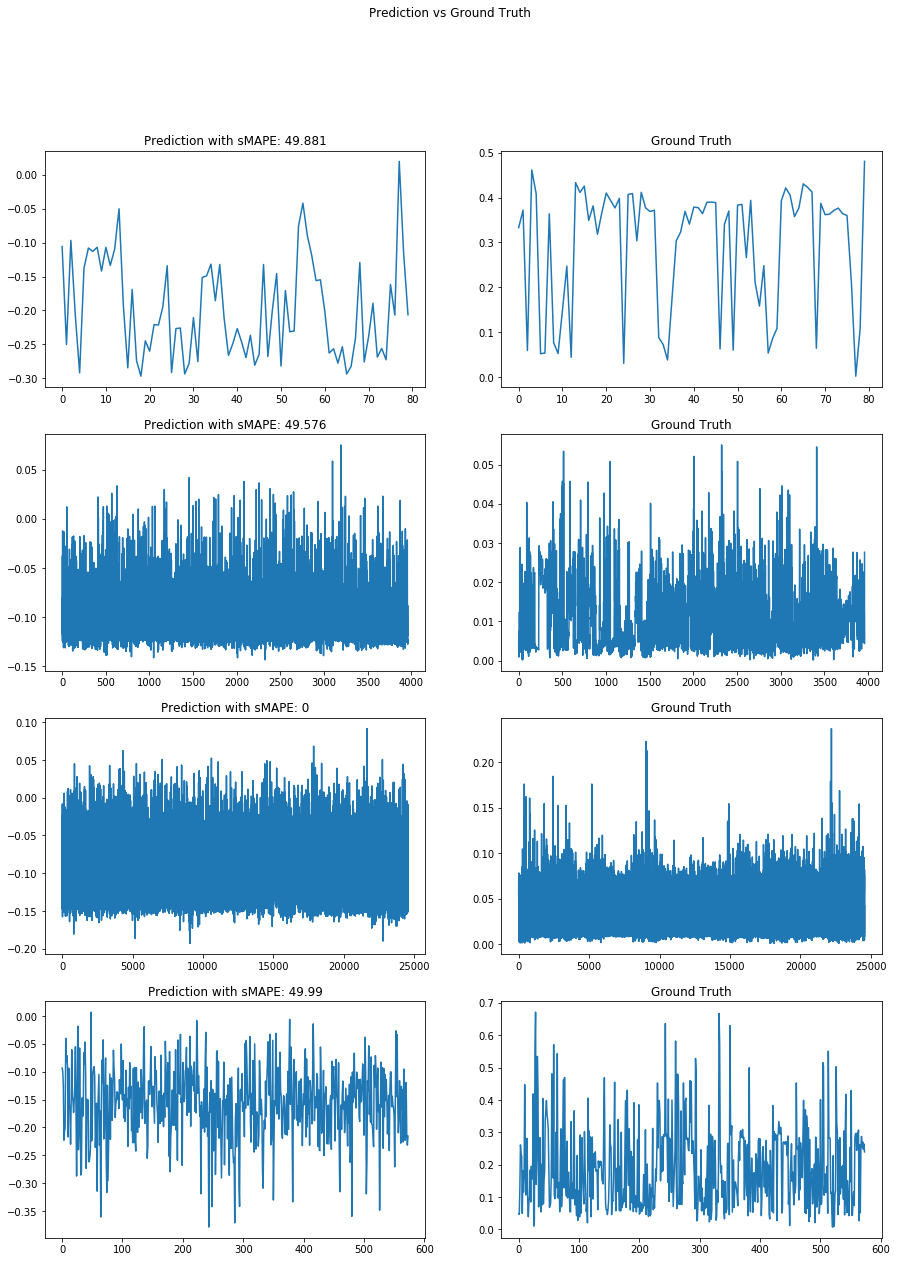

In [56]:
plotters = np.load("plotters_missing_gru.npy")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')

F = plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')

F = plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')

F = plotters[3][0].flatten()
A = plotters[3][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')
fig.suptitle('Prediction vs Ground Truth')
fig.savefig("GRU_M4V2")

### MAML GRU with Missing values

In [29]:
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = True
maml_m4_model = maml_m4(20, layers, units, skip, lr, dr, dictionaries)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [30]:
plotters = []
for i in range(1, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = maml_m4_model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [31]:
np.save("M4_v2_MAML_plotters", plotters)

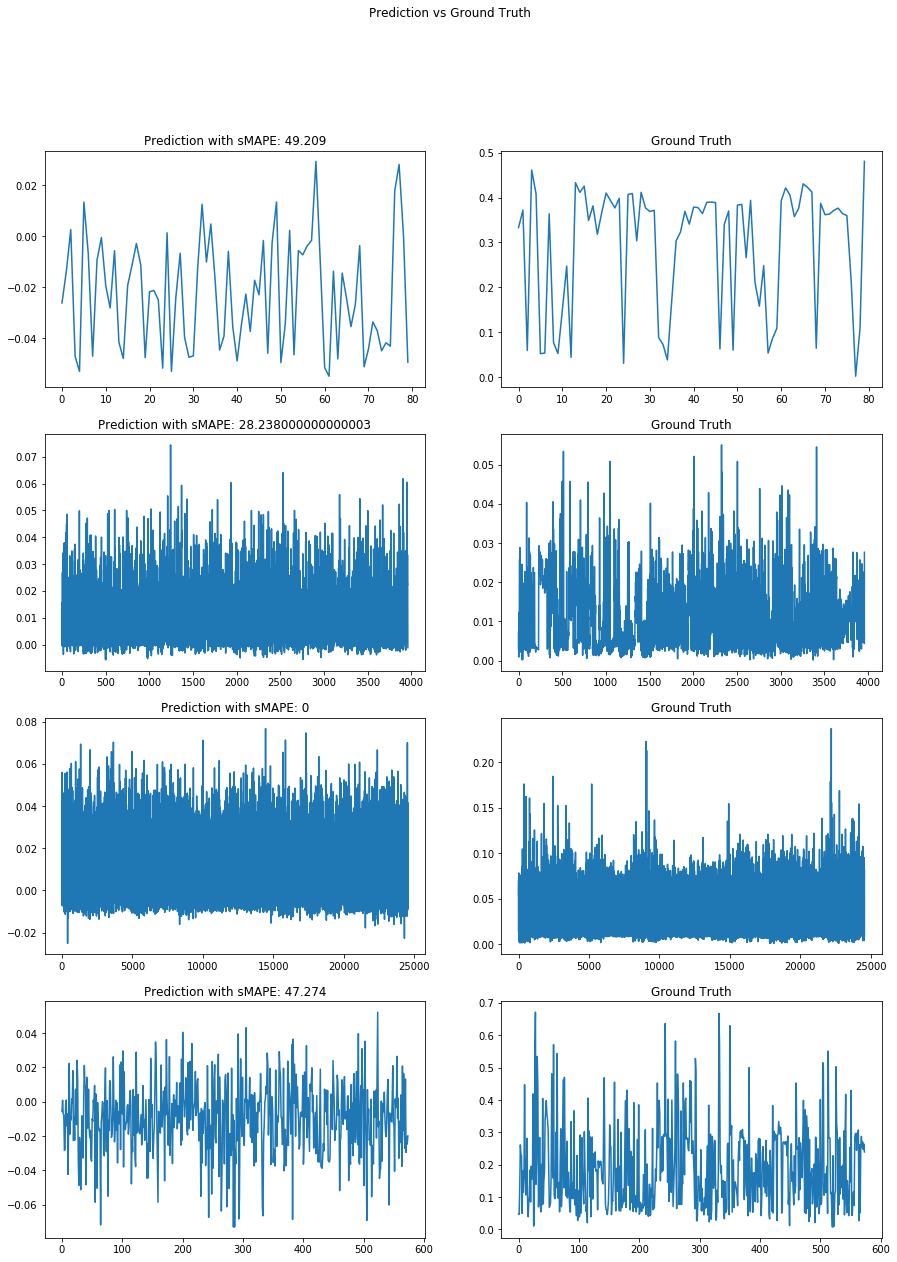

In [57]:
plotters = np.load("M4_v2_MAML_plotters.npy")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')

F = plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')

F = plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')

F = plotters[3][0].flatten()
A = plotters[3][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')
fig.suptitle('Prediction vs Ground Truth')
fig.savefig("MAML_M4V2")

### MAML without missing values in training

In [34]:
dictionaries_without = []
for t in tasks:
    dictionaries_without.append(get_task_ready(t))

In [35]:
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = True
maml_m4_model = maml_m4(20, layers, units, skip, lr, dr, dictionaries_without)

In [36]:
plotters = []
for i in range(1, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = maml_m4_model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [37]:
np.save("plotters_M4_MAML_V2", plotters)

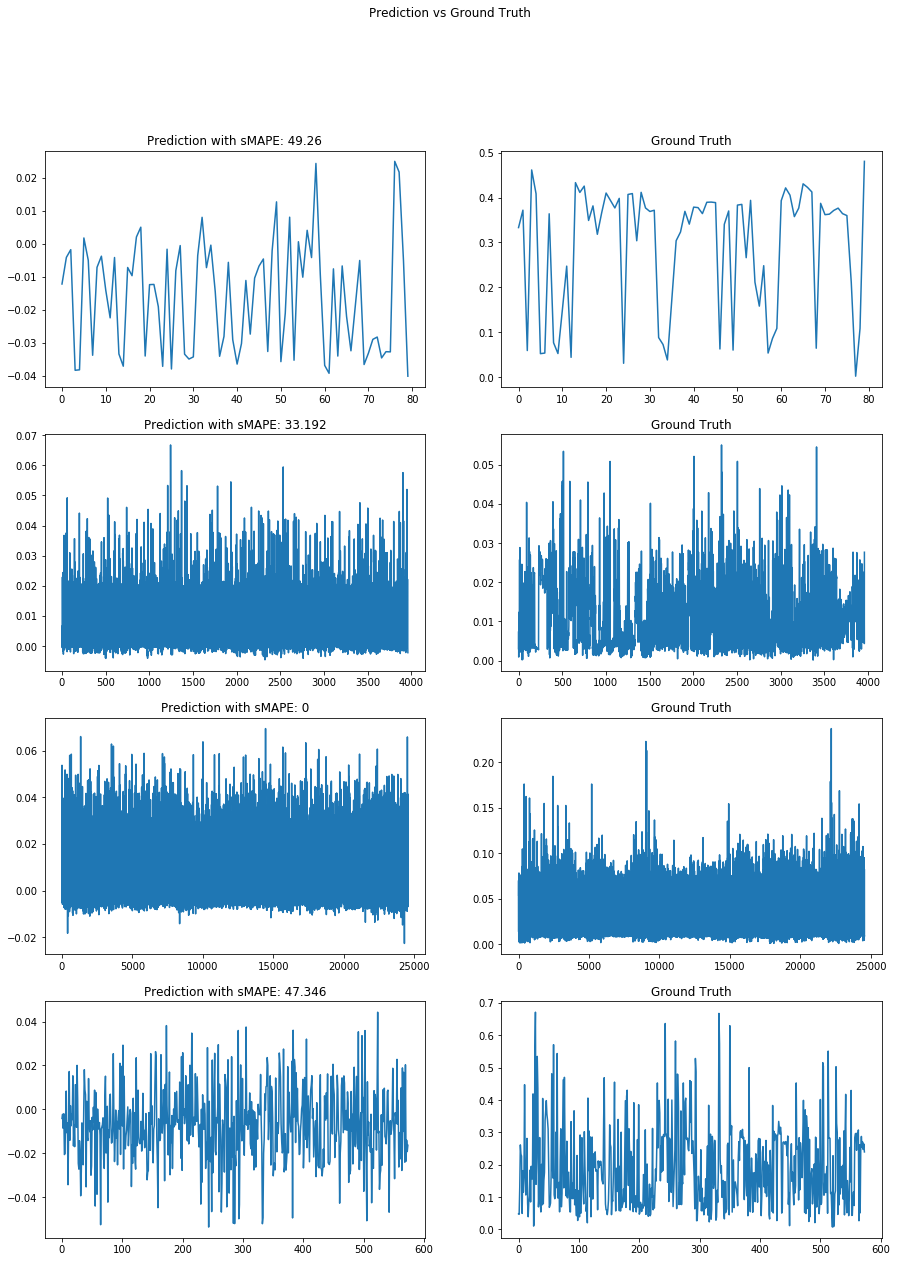

In [58]:
plotters = np.load("plotters_M4_MAML_V2.npy")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')

F = plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')

F = plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')

F = plotters[3][0].flatten()
A = plotters[3][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')
fig.suptitle('Prediction vs Ground Truth')
fig.savefig("GRU_noMissing_M4V2")

### GRU-D With missing values

In [39]:
# GRU-D
d = dictionaries[0]
X = d['X']
mask_X = d['mask_X']
decay_X = d['decay_X']
X = np.concatenate([X, mask_X, decay_X], axis=-1)
X_val = d['X_val']
mask_val = d['mask_val']
decay_val = d['decay_val']
X_val = np.concatenate([X_val, mask_val, decay_val], axis=-1)
y = d['y']
y_val = d['y_val']
min_norm = d['min']
max_norm = d['max']

### GRU-D Multivariate one input

In [40]:
layers = 5
units = 256
lr = 1e-3
dr = 0.2
skip = False
model = GRU_M4(layers, units, lr, dr, skip, X.shape, y.shape)
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=0,
                                                         save_weights_only=True, save_best_only=True)
callbacks = [callback_early, callback_checkpoint]

In [41]:
history = model.fit(x=X, y=y, verbose=0, callbacks=callbacks, epochs=500, batch_size=16, validation_data=[X_val, y_val])

In [42]:
history = history.history

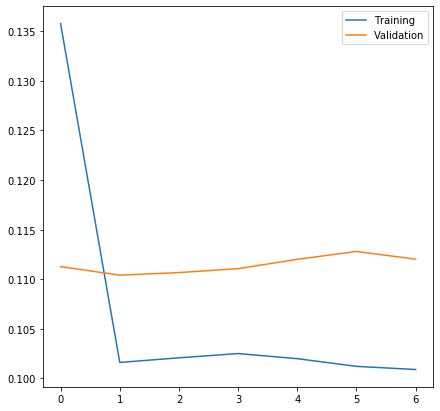

In [43]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.gcf().set_size_inches(7,7)
plt.legend()

In [44]:
plotters = []
for i in range(1, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    mask_tst = dictionaries[i]['mask_tst']
    decay_tst = dictionaries[i]['decay_tst']
    X_tst = np.concatenate([X_tst, mask_tst, decay_tst], axis=-1)
    y_tst = dictionaries[i]['y_tst']
    predictions = []
    for x in X_tst:
        x = np.array([x])
        yp = model.predict(x)
        predictions.append(yp)
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [45]:
np.save("GRU-D-M4_multivariate", plotters)

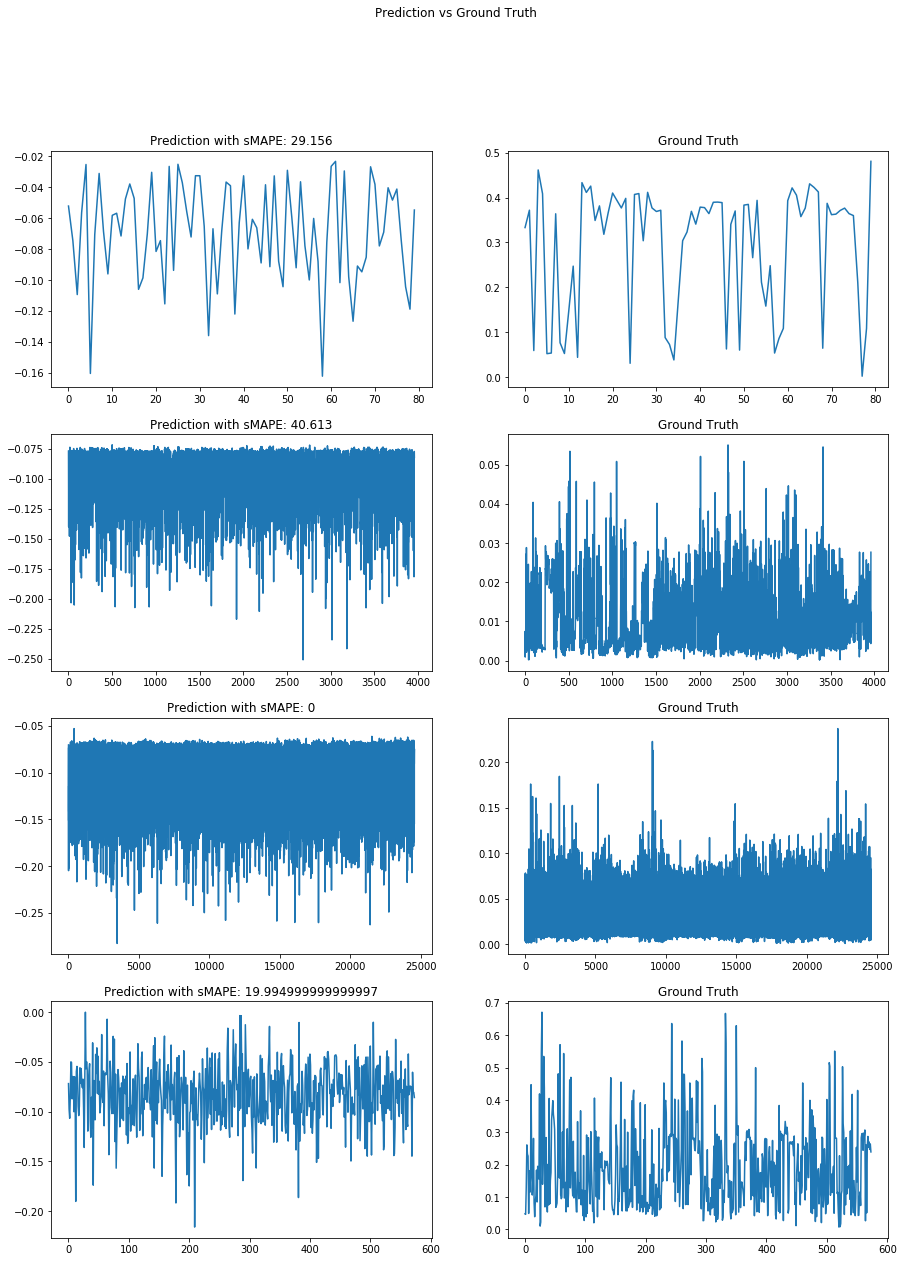

In [60]:
plotters = np.load("GRU-D-M4_multivariate.npy")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')

F = -plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')

F = -plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')

F = -plotters[3][0].flatten()
A = plotters[3][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')
fig.suptitle('Prediction vs Ground Truth')
fig.savefig("GRU-D_M4")

### GRU-D 3 inputs

In [47]:
# 5 layers, 256 units, lr -3, 0.2 drop
def gru_d_m4(layers, units, lr, drop, X, y):
    input_1 = tf.keras.layers.Input(X.shape[1:])
    input_2 = tf.keras.layers.Input(X.shape[1:])
    input_3 = tf.keras.layers.Input(X.shape[1:])
    # First GRU Layer
    gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_1)
    gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_2)
    gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(input_3)
    gru_1 = tf.keras.layers.Dropout(drop)(gru_1)
    gru_2 = tf.keras.layers.Dropout(drop)(gru_2)
    gru_3 = tf.keras.layers.Dropout(drop)(gru_3)
    for i in range(1, layers-1):
        gru_1 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_1)
        gru_1 = tf.keras.layers.Dropout(drop)(gru_1)
        gru_2 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_2)
        gru_2 = tf.keras.layers.Dropout(drop)(gru_2)
        gru_3 = tf.keras.layers.CuDNNGRU(units, return_sequences=True)(gru_3)
        gru_3 = tf.keras.layers.Dropout(drop)(gru_3)
    gru_1 = tf.keras.layers.CuDNNGRU(units)(gru_1)
    gru_2 = tf.keras.layers.CuDNNGRU(units)(gru_2)
    gru_3 = tf.keras.layers.CuDNNGRU(units)(gru_3)
    gru_1 = tf.keras.layers.Dropout(drop)(gru_1)
    gru_2 = tf.keras.layers.Dropout(drop)(gru_2)
    gru_3 = tf.keras.layers.Dropout(drop)(gru_3)
    dense = tf.keras.layers.concatenate([gru_1, gru_2, gru_3])
    dense = tf.keras.layers.Dense(64)(dense)
    output_layer = tf.keras.layers.Dense(y.shape[-1])(dense)
    model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output_layer)
    opt = tf.keras.optimizers.Adagrad(lr)
        #opt = tf.keras.optimizers.SGD(lr)

    model.compile(optimizer=opt, loss=tf.keras.losses.mse,
             metrics=[tf.keras.metrics.mse])
    return model

In [48]:
layers = 5
units = 256
lr = 1e-3
drop = 0.2
d = dictionaries[0]
X = d['X']
mask_X = d['mask_X']
decay_X = d['decay_X']
X_val = d['X_val']
mask_val = d['mask_val']
decay_val = d['decay_val']
y = d['y']
y_val = d['y_val']
min_norm = d['min']
max_norm = d['max']
m4_grud = gru_d_m4(layers, units, lr, drop, X, y)

In [49]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=0,
                                                         save_weights_only=True, save_best_only=True)
callbacks = [callback_early, callback_checkpoint]

In [50]:
history = m4_grud.fit(x=[X, mask_X, decay_X], y=y, verbose=0, callbacks=callbacks, epochs=500, batch_size=16, validation_data=[[X_val, mask_val, decay_val], y_val])

In [51]:
history = history.history

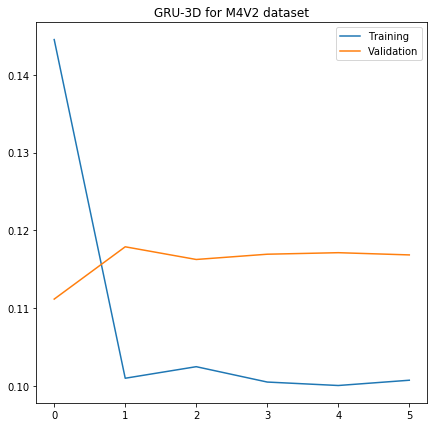

In [52]:
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title("GRU-3D for M4V2 dataset")
plt.gcf().set_size_inches(7,7)
plt.legend()

In [53]:
plotters = []
for i in range(1, len(dictionaries)):
    X_tst = dictionaries[i]['X_tst']
    mask_tst = dictionaries[i]['mask_tst']
    decay_tst = dictionaries[i]['decay_tst']    
    y_tst = dictionaries[i]['y_tst']
    predictions = m4_grud.predict([X_tst, mask_tst, decay_tst])
    predictions = np.array(predictions)
    plotters.append([predictions, y_tst])
plotters = np.array(plotters)

In [54]:
np.save("GRU-3D_plotters", plotters)

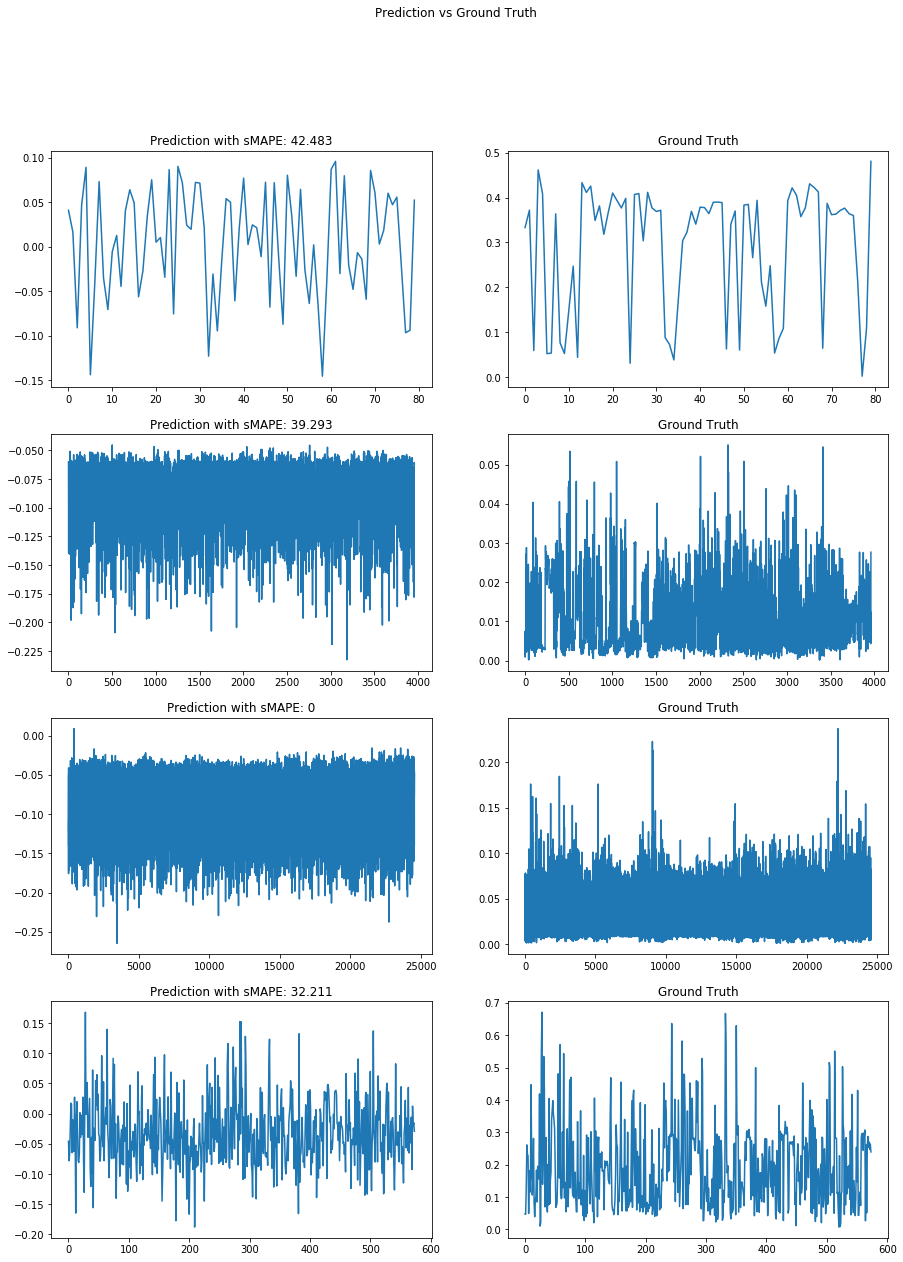

In [72]:
plotters = np.load("GRU-3D_plotters.npy")
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
ax = axs[0,0]
ax.plot(plotters[0][0].flatten(), label='Predictions')

F = -plotters[0][0].flatten()
A = plotters[0][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[0][0].flatten()-plotters[0][1])**2).round(4)

ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[0,1]
ax.plot(plotters[0][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[1,0]
ax.plot(plotters[1][0].flatten(), label='Predictions')

F = -plotters[1][0].flatten()
A = plotters[1][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[1][0].flatten()-plotters[1][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[1,1]
ax.plot(plotters[1][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[2,0]
ax.plot(plotters[2][0].flatten(), label='Predictions')
mse=0
#mse = np.mean((plotters[2][0].flatten()-plotters[2][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[2,1]
ax.plot(plotters[2][1], label='Ground Truth')
ax.set_title('Ground Truth')

ax = axs[3,0]
ax.plot(plotters[3][0].flatten(), label='Predictions')

F = -plotters[3][0].flatten()
A = plotters[3][1]
mse = np.mean((abs(F-A)/(abs(F)+abs(A))/2)).round(5)*100
#mse = np.mean((plotters[3][0].flatten()-plotters[3][1])**2).round(4)
ax.set_title('Prediction with sMAPE: {}'.format(mse))

ax = axs[3,1]
ax.plot(plotters[3][1], label='Ground Truth')
ax.set_title('Ground Truth')
fig.suptitle('Prediction vs Ground Truth')
fig.savefig("GRU-3D_M4V2")

## Loading a checkpoint

In [58]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [109]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 100, 1)       0                                            
__________________________________________________________________________________________________
cu_dnngru_30 (CuDNNGRU)         (None, 100, 128)     50304       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 100, 128)     0           cu_dnngru_30[0][0]               
__________________________________________________________________________________________________
cu_dnngru_31 (CuDNNGRU)         (None, 100, 128)     99072       dropout_34[0][0]                 
__________________________________________________________________________________________________
dropout_35